In [1]:
%load_ext autoreload
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics_from_wandb_run
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics_from_wandb_sweep

from ddls.plotting.plotting import PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import copy

from omegaconf import OmegaConf
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-15 08:52:06,749	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.agents.callbacks` has been deprecated. Use `ray.rllib.algorithms.callbacks` instead. This will raise an error in the future!


Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2022-11-15 08:52:11,771	INFO worker.py:1510 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 


In [2]:
%autoreload

learner_agent_to_beta_dist_to_run_path = {
    
    'PAC-ML (Ours)': {
        
            '$\\beta_{A}$': 'ong/ddls/x08ia9ap',
            # '$\\beta_{B}$': 'ong/ddls-scripts/nhts5bxs',
            '$\\beta_{B}$': 'ong/ddls-scripts/r4rrt0hs',
            '$\\beta_{C}$': 'ong/ddls/1r207clu',
            '$\\beta_{D}$': 'ong/ddls/2np29sr3',
        
    },
    
}



baseline_agent_to_beta_dist_to_sweep_path = {
    
    'Para$_{max}$': {
        
            '$\\beta_{A}$': 'ong/ddls-scripts/xprqeqoh',
            '$\\beta_{B}$': 'ong/ddls-scripts/39cz3lq6',
            '$\\beta_{C}$': 'ong/ddls-scripts/j627d02o',
            '$\\beta_{D}$': 'ong/ddls-scripts/90nahn4v',
        
    },
    
    'Para$_{min}$': {
        
            '$\\beta_{A}$': 'ong/ddls-scripts/lv27j5ia',
            '$\\beta_{B}$': 'ong/ddls-scripts/abxkd48j',
            '$\\beta_{C}$': 'ong/ddls-scripts/olttukv3',
            '$\\beta_{D}$': 'ong/ddls-scripts/4e5i2xy1',
        
    },
    
    'Random': {
        
            '$\\beta_{A}$': 'ong/ddls-scripts/4f1n6nxa',
            '$\\beta_{B}$': 'ong/ddls-scripts/9xz174fq',
            '$\\beta_{C}$': 'ong/ddls-scripts/x6ber86a',
            '$\\beta_{D}$': 'ong/ddls-scripts/3h0qd3ub',
        
    },
    
}

In [3]:
%autoreload

# load learner agent run
keys_to_ignore = ['training/'] # for ignoring data not needed for plotting
key_substrings_to_remove = ['evaluation/'] # for tidying up keys
verbose = True

_learner_agent_to_episode_stats_dict, _learner_agent_to_episode_completion_stats_dict, _learner_agent_to_episode_blocked_stats_dict = defaultdict(list), defaultdict(list), defaultdict(list)
for learner_agent in learner_agent_to_beta_dist_to_run_path.keys():
    # load agent data for each dist
    hue = '$\\beta_{X}$' # grouping by beta dist
    dist_to_run = learner_agent_to_beta_dist_to_run_path[learner_agent]
    learner_agent_to_episode_stats_dict, learner_agent_to_episode_completion_stats_dict, learner_agent_to_episode_blocked_stats_dict = load_ramp_cluster_environment_metrics_from_wandb_run(dist_to_run, keys_to_ignore=keys_to_ignore, key_substrings_to_remove=key_substrings_to_remove, verbose=verbose, hue=hue)
    
    # add agent column
    learner_agent_to_episode_stats_dict['Agent'].extend([learner_agent for _ in range(len(learner_agent_to_episode_stats_dict[hue]))])
    learner_agent_to_episode_completion_stats_dict['Agent'].extend([learner_agent for _ in range(len(learner_agent_to_episode_completion_stats_dict[hue]))])
    learner_agent_to_episode_blocked_stats_dict['Agent'].extend([learner_agent for _ in range(len(learner_agent_to_episode_blocked_stats_dict[hue]))])
    
    # HACK: Forgot to record epoch_counter in completion stats dict and blocked stats dict, need to add manually
    # NOTE: This is only rough approximation since in fact on e.g. first epoch, usually have no completed jobs so no rows added to completion stats, so epoch counters will not be
    # consistent across dataframes. Should only really use this hack if you are just wanting to index e.g. the last epoch rather than indexing specific epochs
    # across different dataframes (e.g. do not index the best epoch since will not be consistent across data frames)
    num_seeds = 3
    learner_agent_to_episode_completion_stats_dict['epoch_counter'].extend([epoch_counter for _ in range(num_seeds) for epoch_counter in range(int(len(learner_agent_to_episode_completion_stats_dict[hue]) / num_seeds))])
    if len(learner_agent_to_episode_completion_stats_dict['epoch_counter']) < len(learner_agent_to_episode_completion_stats_dict[hue]):
        # quit run before other seeds could finish, need to add final epoch seed(s) manually to make all columns in df the same length
        final_epoch = learner_agent_to_episode_completion_stats_dict['epoch_counter'][-1] + 1
        for _ in range(int(len(learner_agent_to_episode_completion_stats_dict[hue]) - len(learner_agent_to_episode_completion_stats_dict['epoch_counter']))):
            learner_agent_to_episode_completion_stats_dict['epoch_counter'].append(final_epoch)
    learner_agent_to_episode_blocked_stats_dict['epoch_counter'].extend([epoch_counter for _ in range(num_seeds) for epoch_counter in range(int(len(learner_agent_to_episode_blocked_stats_dict[hue]) / num_seeds))])
    if len(learner_agent_to_episode_blocked_stats_dict['epoch_counter']) < len(learner_agent_to_episode_blocked_stats_dict[hue]):
        # quit run before other seeds could finish, need to add final epoch seed(s) manually to make all columns in df the same length
        final_epoch = learner_agent_to_episode_blocked_stats_dict['epoch_counter'][-1] + 1
        for _ in range(int(len(learner_agent_to_episode_blocked_stats_dict[hue]) - len(learner_agent_to_episode_blocked_stats_dict['epoch_counter']))):
            learner_agent_to_episode_blocked_stats_dict['epoch_counter'].append(final_epoch)
            
    # merge learner agent df into all learner agents df
    for key, val in learner_agent_to_episode_stats_dict.items():
        _learner_agent_to_episode_stats_dict[key].extend(val)
    for key, val in learner_agent_to_episode_completion_stats_dict.items():
        _learner_agent_to_episode_completion_stats_dict[key].extend(val)
    for key, val in learner_agent_to_episode_blocked_stats_dict.items():
        _learner_agent_to_episode_blocked_stats_dict[key].extend(val)
            
# remove leading underscore for readability
learner_agent_to_episode_stats_dict, learner_agent_to_episode_completion_stats_dict, learner_agent_to_episode_blocked_stats_dict = _learner_agent_to_episode_stats_dict, _learner_agent_to_episode_completion_stats_dict, _learner_agent_to_episode_blocked_stats_dict

    
# convert dicts to dataframes
learner_agent_episode_stats_df = pd.DataFrame(learner_agent_to_episode_stats_dict)
display(learner_agent_episode_stats_df)

for key, val in learner_agent_to_episode_completion_stats_dict.items():
    print(f'key {key} -> {len(val)} vals')
learner_agent_episode_completion_stats_df = pd.DataFrame(learner_agent_to_episode_completion_stats_dict)
display(learner_agent_episode_completion_stats_df)

for key, val in learner_agent_to_episode_blocked_stats_dict.items():
    print(f'key {key} -> {len(val)} vals')
learner_agent_episode_blocked_stats_df = pd.DataFrame(learner_agent_to_episode_blocked_stats_dict)
display(learner_agent_episode_blocked_stats_df)


Recorded keys: {'evaluation/cluster_info_processed_mean', 'evaluation/jobs_blocked_num_nodes_min', 'evaluation/jobs_completed_max_acceptable_job_completion_time_mean', 'evaluation/mean_flow_throughput_min', 'evaluation/jobs_completed_num_edges_mean', 'evaluation/mean_demand_total_throughput_max', 'evaluation/mean_mounted_worker_utilisation_frac_min', 'evaluation/jobs_blocked_total_dependency_size_max', 'evaluation/jobs_completed_total_operation_memory_cost_max', 'evaluation/episode_start_time_max', 'evaluation/blocking_rate_min', 'evaluation/episodes_this_iter', 'evaluation/episode_end_time_min', 'evaluation/cluster_info_processed_min', 'evaluation/jobs_blocked_max_acceptable_job_completion_time_frac_max', 'evaluation/step_time_mean', 'evaluation/jobs_completed_job_sequential_completion_time_max', 'evaluation/mean_num_jobs_running_min', 'evaluation/jobs_completed_max_acceptable_job_completion_time_max', 'evaluation/jobs_completed_original_demand_num_nodes_max', 'evaluation/job_queue_l

,mean_mounted_worker_utilisation_frac_mean,mean_mounted_worker_utilisation_frac_max,episode_reward_max,flow_info_processed_mean,mean_num_jobs_running_mean,mean_demand_compute_throughput_mean,dep_info_processed_mean,dep_info_processed_min,mean_cluster_worker_utilisation_frac_mean,num_jobs_blocked_max,...,num_jobs_arrived_max,compute_info_processed_mean,mean_demand_compute_throughput_min,demand_dep_info_processed_max,mean_communication_overhead_frac_mean,mean_demand_total_throughput_min,mean_load_rate_max,episode_start_time_min,$\beta_{X}$,Agent
0,0.000000e+00,0.000000e+00,-1000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,...,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.162332e+07,0,$\beta_{A}$,PAC-ML (Ours)
1,0.000000e+00,0.000000e+00,-1000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,...,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.156234e+07,0,$\beta_{A}$,PAC-ML (Ours)
2,0.000000e+00,0.000000e+00,-1000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,...,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.159283e+07,0,$\beta_{A}$,PAC-ML (Ours)
3,0.000000e+00,0.000000e+00,-1000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,...,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.161611e+07,0,$\beta_{A}$,PAC-ML (Ours)
4,0.000000e+00,0.000000e+00,-1000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,...,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.159283e+07,0,$\beta_{A}$,PAC-ML (Ours)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,4.922830e+06,7.328337e+06,846,1.392378e+13,13.367000,1.410547e+07,2.153358e+13,2.139938e+13,4.128312e+06,106,...,1001,1.410547e+13,1.401358e+07,1.446661e+13,0.000188,2.826119e+07,3.167275e+07,0,$\beta_{D}$,PAC-ML (Ours)
1065,4.940396e+06,8.418230e+06,828,1.382344e+13,13.317000,1.400386e+07,2.138129e+13,2.118714e+13,4.118171e+06,110,...,1001,1.400386e+13,1.389112e+07,1.431124e+13,0.000188,2.798920e+07,3.156234e+07,0,$\beta_{D}$,PAC-ML (Ours)
1066,4.946252e+06,7.899302e+06,812,1.383654e+13,13.258333,1.402108e+07,2.139056e+13,2.128791e+13,4.096123e+06,111,...,1001,1.402108e+13,1.396126e+07,1.429002e+13,0.000189,2.812903e+07,3.161404e+07,0,$\beta_{D}$,PAC-ML (Ours)
1067,4.926589e+06,7.380375e+06,826,1.392033e+13,13.350667,1.410006e+07,2.153123e+13,2.118138e+13,4.121842e+06,108,...,1001,1.410006e+13,1.388438e+07,1.445178e+13,0.000188,2.798197e+07,3.156876e+07,0,$\beta_{D}$,PAC-ML (Ours)


key job_completion_time_speedup_mean -> 1044 vals
key jobs_completed_total_dependency_size_max -> 1044 vals
key jobs_completed_max_acceptable_job_completion_time_mean -> 1044 vals
key job_communication_overhead_time_max -> 1044 vals
key jobs_completed_num_mounted_workers_min -> 1044 vals
key job_completion_time_speedup_min -> 1044 vals
key jobs_completed_max_partitions_per_op_mean -> 1044 vals
key jobs_completed_max_acceptable_job_completion_time_frac_mean -> 1044 vals
key jobs_completed_num_edges_max -> 1044 vals
key jobs_completed_max_acceptable_job_completion_time_frac_min -> 1044 vals
key jobs_completed_original_demand_total_operation_memory_cost_min -> 1044 vals
key jobs_completed_job_sequential_completion_time_mean -> 1044 vals
key jobs_completed_mean_mounted_worker_utilisation_frac_mean -> 1044 vals
key jobs_completed_total_operation_memory_cost_min -> 1044 vals
key jobs_completed_mean_mounted_worker_utilisation_frac_max -> 1044 vals
key job_completion_time_speedup_max -> 1044 v

,job_completion_time_speedup_mean,jobs_completed_total_dependency_size_max,jobs_completed_max_acceptable_job_completion_time_mean,job_communication_overhead_time_max,jobs_completed_num_mounted_workers_min,job_completion_time_speedup_min,jobs_completed_max_partitions_per_op_mean,jobs_completed_max_acceptable_job_completion_time_frac_mean,jobs_completed_num_edges_max,jobs_completed_max_acceptable_job_completion_time_frac_min,...,job_completion_time_min,job_completion_time_max,job_communication_overhead_time_mean,jobs_completed_total_dependency_size_mean,job_communication_overhead_time_min,jobs_completed_max_acceptable_job_completion_time_frac_max,jobs_completed_num_mounted_channels_max,$\beta_{X}$,Agent,epoch_counter
0,7.984287,1.366602e+11,33256.979314,8.528821,8.000000,7.984287,8.000000,0.963263,6474.000000,0.945455,...,4324.161851,4324.161851,8.528821,1.366602e+11,8.528821,0.983333,56.0,$\beta_{A}$,PAC-ML (Ours),0
1,7.984287,1.366602e+11,31992.614166,8.528821,8.000000,7.984287,8.000000,0.926641,6474.000000,0.909524,...,4324.161851,4324.161851,8.528821,1.366602e+11,8.528821,0.951600,56.0,$\beta_{A}$,PAC-ML (Ours),1
2,7.984287,1.366602e+11,31382.994961,8.528821,8.000000,7.984287,8.000000,0.908984,6474.000000,0.890244,...,4324.161851,4324.161851,8.528821,1.366602e+11,8.528821,0.926364,56.0,$\beta_{A}$,PAC-ML (Ours),2
3,7.874956,1.366602e+11,29513.856128,8.528821,7.764706,7.749798,7.890319,0.853856,6474.000000,0.832000,...,4324.161851,4872.823631,8.367708,1.339617e+11,8.170715,0.870156,56.0,$\beta_{A}$,PAC-ML (Ours),3
4,7.844884,1.366602e+11,28638.855700,8.528821,7.803922,7.632377,7.860131,0.828799,6474.000000,0.808986,...,4324.161851,4846.712526,8.428434,1.340511e+11,8.297693,0.858000,56.0,$\beta_{A}$,PAC-ML (Ours),4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,1.999739,2.383190e+10,21880.666623,2.822531,2.000000,1.999738,2.000000,0.734572,415.426174,0.733647,...,14858.302036,14955.821726,2.813701,2.376390e+10,2.806147,0.736197,2.0,$\beta_{D}$,PAC-ML (Ours),343
1040,1.999740,2.393668e+10,22086.413121,2.834639,2.000000,1.999739,2.000000,0.739506,416.223596,0.735738,...,14860.493631,15013.632708,2.802080,2.366379e+10,2.780842,0.743528,2.0,$\beta_{D}$,PAC-ML (Ours),344
1041,1.999739,2.380619e+10,22021.635956,2.818966,2.000000,1.999738,2.000000,0.738128,416.035794,0.733948,...,14862.342185,14964.578874,2.808674,2.372528e+10,2.794097,0.741622,2.0,$\beta_{D}$,PAC-ML (Ours),345
1042,1.999739,2.391429e+10,22030.847381,2.830550,2.000000,1.999737,2.000000,0.738377,414.872364,0.733478,...,14855.563431,14978.883989,2.811226,2.374233e+10,2.776940,0.741087,2.0,$\beta_{D}$,PAC-ML (Ours),346


key jobs_blocked_num_nodes_max -> 1069 vals
key jobs_blocked_num_edges_max -> 1069 vals
key jobs_blocked_original_demand_num_nodes_max -> 1069 vals
key jobs_blocked_max_acceptable_job_completion_time_mean -> 1069 vals
key jobs_blocked_original_demand_num_edges_mean -> 1069 vals
key jobs_blocked_total_dependency_size_max -> 1069 vals
key jobs_blocked_num_nodes_min -> 1069 vals
key jobs_blocked_original_demand_num_nodes_min -> 1069 vals
key jobs_blocked_original_demand_total_operation_memory_cost_min -> 1069 vals
key jobs_blocked_original_demand_total_dependency_size_min -> 1069 vals
key jobs_blocked_num_nodes_mean -> 1069 vals
key jobs_blocked_original_demand_total_dependency_size_max -> 1069 vals
key jobs_blocked_total_dependency_size_mean -> 1069 vals
key jobs_blocked_original_demand_total_operation_memory_cost_mean -> 1069 vals
key jobs_blocked_job_sequential_completion_time_min -> 1069 vals
key jobs_blocked_max_acceptable_job_completion_time_frac_mean -> 1069 vals
key jobs_blocked_m

,jobs_blocked_num_nodes_max,jobs_blocked_num_edges_max,jobs_blocked_original_demand_num_nodes_max,jobs_blocked_max_acceptable_job_completion_time_mean,jobs_blocked_original_demand_num_edges_mean,jobs_blocked_total_dependency_size_max,jobs_blocked_num_nodes_min,jobs_blocked_original_demand_num_nodes_min,jobs_blocked_original_demand_total_operation_memory_cost_min,jobs_blocked_original_demand_total_dependency_size_min,...,jobs_blocked_total_operation_memory_cost_mean,jobs_blocked_max_acceptable_job_completion_time_frac_min,jobs_blocked_max_acceptable_job_completion_time_max,jobs_blocked_original_demand_num_edges_max,jobs_blocked_original_demand_total_operation_memory_cost_max,jobs_blocked_job_sequential_completion_time_mean,jobs_blocked_total_operation_memory_cost_max,$\beta_{X}$,Agent,epoch_counter
0,100.496000,111.912000,100.496000,16556.840221,111.849333,1.594830e+10,100.406000,100.406000,1.564455e+10,1.590290e+10,...,1.566618e+10,0.542820,16717.139375,111.912000,1.568753e+10,29944.850467,1.568753e+10,$\beta_{A}$,PAC-ML (Ours),0
1,100.418000,111.834000,100.418000,16475.567237,111.725333,1.592421e+10,100.290000,100.290000,1.561901e+10,1.588348e+10,...,1.564112e+10,0.532670,16840.607368,111.834000,1.566630e+10,29956.443583,1.566630e+10,$\beta_{A}$,PAC-ML (Ours),1
2,100.460000,111.876000,100.460000,16568.687749,111.776000,1.591364e+10,100.318000,100.318000,1.560978e+10,1.586733e+10,...,1.563553e+10,0.543260,16827.603432,111.876000,1.565791e+10,29934.495483,1.565791e+10,$\beta_{A}$,PAC-ML (Ours),2
3,100.490000,111.906000,100.490000,16399.179505,111.784667,1.593757e+10,100.238000,100.238000,1.565911e+10,1.591568e+10,...,1.566847e+10,0.541420,16585.296061,111.906000,1.567417e+10,29944.377667,1.567417e+10,$\beta_{A}$,PAC-ML (Ours),3
4,100.450000,111.842000,100.450000,16439.400948,111.804667,1.594052e+10,100.386000,100.386000,1.564455e+10,1.590290e+10,...,1.566240e+10,0.528800,17155.459731,111.842000,1.568051e+10,29977.155150,1.568051e+10,$\beta_{A}$,PAC-ML (Ours),4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,105.648352,117.153846,105.648352,19335.090189,114.177068,1.807224e+10,101.037736,101.037736,1.624270e+10,1.647070e+10,...,1.670262e+10,0.609780,19892.191797,117.153846,1.741721e+10,31039.012136,1.741721e+10,$\beta_{D}$,PAC-ML (Ours),352
1065,107.257143,119.457143,107.257143,18464.332733,113.139586,1.804458e+10,98.505051,98.505051,1.542213e+10,1.558575e+10,...,1.681750e+10,0.579899,19408.752224,119.457143,1.751934e+10,30767.594084,1.751934e+10,$\beta_{D}$,PAC-ML (Ours),353
1066,106.414414,118.405405,106.414414,19140.542133,113.512494,1.788752e+10,98.132075,98.132075,1.611146e+10,1.651075e+10,...,1.652663e+10,0.602432,19608.219703,118.405405,1.728443e+10,31174.360655,1.728443e+10,$\beta_{D}$,PAC-ML (Ours),354
1067,104.092593,115.092593,104.092593,19416.156854,114.307969,1.859787e+10,102.340000,102.340000,1.528164e+10,1.569513e+10,...,1.643438e+10,0.604352,19861.501365,115.092593,1.810359e+10,31331.393332,1.810359e+10,$\beta_{D}$,PAC-ML (Ours),355


In [4]:
%autoreload

# load baseline agent sweep
keys_to_ignore = ['valid/step_stats/'] # for ignoring data not needed for plotting
key_substrings_to_remove = ['valid/episode_stats/'] # for tidying up keys
verbose = False

_baseline_agent_to_episode_stats_dict, _baseline_agent_to_episode_completion_stats_dict, _baseline_agent_to_episode_blocked_stats_dict = defaultdict(list), defaultdict(list), defaultdict(list)
for baseline_agent in baseline_agent_to_beta_dist_to_sweep_path.keys():
    # load agent data for each dist
    hue = '$\\beta_{X}$' # grouping by beta dist
    dist_to_run = baseline_agent_to_beta_dist_to_sweep_path[baseline_agent]
    baseline_agent_to_episode_stats_dict, baseline_agent_to_episode_completion_stats_dict, baseline_agent_to_episode_blocked_stats_dict = load_ramp_cluster_environment_metrics_from_wandb_sweep(dist_to_run, keys_to_ignore=keys_to_ignore, key_substrings_to_remove=key_substrings_to_remove, verbose=verbose, hue=hue)
    
    # add agent column
    baseline_agent_to_episode_stats_dict['Agent'].extend([baseline_agent for _ in range(len(baseline_agent_to_episode_stats_dict[hue]))])
    baseline_agent_to_episode_completion_stats_dict['Agent'].extend([baseline_agent for _ in range(len(baseline_agent_to_episode_completion_stats_dict[hue]))])
    baseline_agent_to_episode_blocked_stats_dict['Agent'].extend([baseline_agent for _ in range(len(baseline_agent_to_episode_blocked_stats_dict[hue]))])
    
    # merge learner agent df into all learner agents df
    for key, val in baseline_agent_to_episode_stats_dict.items():
        _baseline_agent_to_episode_stats_dict[key].extend(val)
    for key, val in baseline_agent_to_episode_completion_stats_dict.items():
        _baseline_agent_to_episode_completion_stats_dict[key].extend(val)
    for key, val in baseline_agent_to_episode_blocked_stats_dict.items():
        _baseline_agent_to_episode_blocked_stats_dict[key].extend(val)

    
# remove leading underscore for readability        
baseline_agent_to_episode_stats_dict, baseline_agent_to_episode_completion_stats_dict, baseline_agent_to_episode_blocked_stats_dict = _baseline_agent_to_episode_stats_dict, _baseline_agent_to_episode_completion_stats_dict, _baseline_agent_to_episode_blocked_stats_dict
        
# convert dicts to dataframes
# for key, val in baseline_agent_to_episode_stats_dict.items():
#     print(f'key {key} -> {len(val)} vals')
baseline_agent_episode_stats_df = pd.DataFrame(baseline_agent_to_episode_stats_dict)
display(baseline_agent_episode_stats_df)

baseline_agent_episode_completion_stats_df = pd.DataFrame(baseline_agent_to_episode_completion_stats_dict)
display(baseline_agent_episode_completion_stats_df)

baseline_agent_episode_blocked_stats_df = pd.DataFrame(baseline_agent_to_episode_blocked_stats_dict)
display(baseline_agent_episode_blocked_stats_df)


Agent $\beta_{A}$ sweep <Sweep ong/ddls-scripts/xprqeqoh (FINISHED)> parameters:
	experiment.seed:
		{'values': [0, 1, 2]}
Loading data from 3 runs...
Loaded data for run 1 of 3 (<Run ong/ddls-scripts/7k4hh7ns (finished)>) in 0.410.
Loaded data for run 2 of 3 (<Run ong/ddls-scripts/nfm6liua (finished)>) in 0.422.
Loaded data for run 3 of 3 (<Run ong/ddls-scripts/4381qrv3 (finished)>) in 0.425.
Loaded data for agent $\beta_{A}$ sweep <Sweep ong/ddls-scripts/xprqeqoh (FINISHED)> (num_runs=3) in 1.257 s.

Agent $\beta_{B}$ sweep <Sweep ong/ddls-scripts/39cz3lq6 (FINISHED)> parameters:
	experiment.seed:
		{'values': [0, 1, 2]}
Loading data from 3 runs...
Loaded data for run 1 of 3 (<Run ong/ddls-scripts/hi7b14qz (finished)>) in 0.403.
Loaded data for run 2 of 3 (<Run ong/ddls-scripts/7e4o6iek (finished)>) in 0.420.
Loaded data for run 3 of 3 (<Run ong/ddls-scripts/0biqxyqw (finished)>) in 0.417.
Loaded data for agent $\beta_{B}$ sweep <Sweep ong/ddls-scripts/39cz3lq6 (FINISHED)> (num_runs

,dep_info_processed,num_jobs_arrived,blocking_rate,episode_end_time,mean_demand_total_throughput,compute_info_processed,num_jobs_blocked,mean_demand_compute_throughput,episode_time,demand_dep_info_processed,...,demand_total_info_processed,mean_dep_throughput,cluster_info_processed,mean_compute_throughput,mean_load_rate,mean_cluster_throughput,$\beta_{X}$,config,experiment.seed,Agent
0,9.048242e+13,1001,0.259740,1000000,2.328156e+07,1.155744e+13,260,1.155744e+07,1000000,1.172412e+13,...,2.328156e+13,9.048242e+07,1.020399e+14,1.155744e+07,3.157920e+07,1.020399e+08,$\beta_{A}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$
1,8.941673e+13,1001,0.262737,1000000,2.301142e+07,1.141525e+13,263,1.141525e+07,1000000,1.159617e+13,...,2.301142e+13,8.941673e+07,1.008320e+14,1.141525e+07,3.151933e+07,1.008320e+08,$\beta_{A}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1,Para$_{max}$
2,9.079394e+13,1001,0.264735,1000000,2.344749e+07,1.162064e+13,265,1.162064e+07,1000000,1.182685e+13,...,2.344749e+13,9.079394e+07,1.024146e+14,1.162064e+07,3.146476e+07,1.024146e+08,$\beta_{A}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0,Para$_{max}$
3,9.066860e+13,1001,0.261738,1000000,2.331935e+07,1.157350e+13,262,1.157350e+07,1000000,1.174585e+13,...,2.331935e+13,9.066860e+07,1.022421e+14,1.157350e+07,3.161611e+07,1.022421e+08,$\beta_{B}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$
4,9.160306e+13,1001,0.268731,1000000,2.368586e+07,1.172550e+13,269,1.172550e+07,1000000,1.196036e+13,...,2.368586e+13,9.160306e+07,1.033286e+14,1.172550e+07,3.159283e+07,1.033286e+08,$\beta_{B}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1,Para$_{max}$
5,9.137898e+13,1001,0.258741,1000000,2.351176e+07,1.166970e+13,259,1.166970e+07,1000000,1.184206e+13,...,2.351176e+13,9.137898e+07,1.030487e+14,1.166970e+07,3.163812e+07,1.030487e+08,$\beta_{B}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0,Para$_{max}$
6,9.066860e+13,1001,0.261738,1000000,2.331935e+07,1.157350e+13,262,1.157350e+07,1000000,1.174585e+13,...,2.331935e+13,9.066860e+07,1.022421e+14,1.157350e+07,3.161611e+07,1.022421e+08,$\beta_{C}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$
7,9.160306e+13,1001,0.268731,1000000,2.368586e+07,1.172550e+13,269,1.172550e+07,1000000,1.196036e+13,...,2.368586e+13,9.160306e+07,1.033286e+14,1.172550e+07,3.159283e+07,1.033286e+08,$\beta_{C}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1,Para$_{max}$
8,9.185167e+13,1001,0.271728,1000000,2.366218e+07,1.172462e+13,272,1.172462e+07,1000000,1.193756e+13,...,2.366218e+13,9.185167e+07,1.035763e+14,1.172462e+07,3.162746e+07,1.035763e+08,$\beta_{C}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0,Para$_{max}$
9,9.066860e+13,1001,0.261738,1000000,2.331935e+07,1.157350e+13,262,1.157350e+07,1000000,1.174585e+13,...,2.331935e+13,9.066860e+07,1.022421e+14,1.157350e+07,3.161611e+07,1.022421e+08,$\beta_{D}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$


,jobs_completed_max_partitions_per_op,job_communication_overhead_time,jobs_completed_original_demand_num_nodes,jobs_completed_num_edges,job_computation_overhead_time,jobs_completed_max_acceptable_job_completion_time_frac,jobs_completed_original_demand_total_operation_memory_cost,jobs_completed_max_acceptable_job_completion_time,jobs_completed_job_sequential_completion_time,jobs_completed_original_demand_num_edges,...,jobs_completed_total_dependency_size,job_completion_time_speedup,jobs_completed_total_operation_memory_cost,jobs_completed_num_mounted_channels,jobs_completed_mean_mounted_worker_utilisation_frac,jobs_completed_num_mounted_workers,$\beta_{X}$,config,experiment.seed,Agent
0,16.000000,4.474958,99.713514,24824.378378,1865.629267,0.552851,1.560399e+10,16467.144936,29755.115405,111.027027,...,1.221730e+11,15.663282,1.560399e+10,242.854054,3.656071e+05,16.081081,$\beta_{A}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$
1,16.000000,4.422981,100.358209,25142.721845,1877.668174,0.561927,1.546841e+10,16799.816123,29950.485075,111.751696,...,1.211649e+11,15.672534,1.546841e+10,242.626866,3.687270e+05,16.074627,$\beta_{A}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1,Para$_{max}$
2,16.000000,4.506721,101.224490,25285.753741,1870.121754,0.549524,1.578809e+10,16421.602376,29827.598299,112.814966,...,1.233532e+11,15.665247,1.578809e+10,245.268027,3.766328e+05,16.149660,$\beta_{A}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0,Para$_{max}$
3,16.000000,4.497680,99.994580,25022.878049,1875.050945,0.265298,1.567859e+10,7894.040075,29908.106369,111.292683,...,1.228269e+11,15.670423,1.567859e+10,245.008130,3.676363e+05,16.142276,$\beta_{B}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$
4,16.000000,4.580708,101.600547,25744.831737,1900.665455,0.277729,1.603666e+10,8388.113936,30323.351778,113.073871,...,1.252814e+11,15.687805,1.603666e+10,244.574555,3.854119e+05,16.129959,$\beta_{B}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1,Para$_{max}$
5,16.000000,4.503673,100.267206,24966.862348,1863.715317,0.284251,1.571046e+10,8517.199163,29723.995951,111.680162,...,1.229960e+11,15.661498,1.571046e+10,244.512821,3.683223e+05,16.128205,$\beta_{B}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0,Para$_{max}$
6,16.000000,4.497680,99.994580,25022.878049,1875.050945,0.518645,1.567859e+10,15484.348146,29908.106369,111.292683,...,1.228269e+11,15.670423,1.567859e+10,245.008130,3.676363e+05,16.142276,$\beta_{C}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$
7,16.000000,4.580708,101.600547,25744.831737,1900.665455,0.470109,1.603666e+10,14204.063406,30323.351778,113.073871,...,1.252814e+11,15.687805,1.603666e+10,244.574555,3.854119e+05,16.129959,$\beta_{C}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1,Para$_{max}$
8,16.000000,4.613982,100.590659,25669.802198,1916.154737,0.467335,1.606645e+10,14342.471047,30575.263393,111.739011,...,1.258417e+11,15.700686,1.606645e+10,242.901099,3.801781e+05,16.082418,$\beta_{C}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0,Para$_{max}$
9,16.000000,4.497680,99.994580,25022.878049,1875.050945,0.706694,1.567859e+10,21122.246735,29908.106369,111.292683,...,1.228269e+11,15.670423,1.567859e+10,245.008130,3.676363e+05,16.142276,$\beta_{D}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$


,jobs_blocked_original_demand_num_nodes,jobs_blocked_max_acceptable_job_completion_time,jobs_blocked_original_demand_total_dependency_size,jobs_blocked_max_acceptable_job_completion_time_frac,jobs_blocked_num_nodes,jobs_blocked_original_demand_num_edges,jobs_blocked_total_dependency_size,jobs_blocked_job_sequential_completion_time,jobs_blocked_total_operation_memory_cost,jobs_blocked_num_edges,jobs_blocked_original_demand_total_operation_memory_cost,$\beta_{X}$,config,experiment.seed,Agent
0,101.753846,16258.030558,1.613121e+10,0.529500,101.753846,113.276923,1.613121e+10,30475.478462,1.578636e+10,113.276923,1.578636e+10,$\beta_{A}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$
1,100.365019,16621.325618,1.637013e+10,0.566198,100.365019,111.798479,1.637013e+10,29802.749620,1.608153e+10,111.798479,1.608153e+10,$\beta_{A}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1,Para$_{max}$
2,98.000000,16506.153096,1.534490e+10,0.546340,98.000000,108.871698,1.534490e+10,30271.997170,1.514234e+10,108.871698,1.514234e+10,$\beta_{A}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0,Para$_{max}$
3,101.885496,8459.734977,1.600713e+10,0.279237,101.885496,113.633588,1.600713e+10,30056.933206,1.566171e+10,113.633588,1.566171e+10,$\beta_{B}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$
4,96.936803,8003.270801,1.470419e+10,0.276766,96.936803,108.078067,1.470419e+10,28904.516914,1.462869e+10,108.078067,1.462869e+10,$\beta_{B}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1,Para$_{max}$
5,101.459459,8602.256811,1.601674e+10,0.284981,101.459459,112.961390,1.601674e+10,30457.497490,1.567420e+10,112.961390,1.567420e+10,$\beta_{B}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0,Para$_{max}$
6,101.885496,16052.311901,1.600713e+10,0.531489,101.885496,113.633588,1.600713e+10,30056.933206,1.566171e+10,113.633588,1.566171e+10,$\beta_{C}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$
7,96.936803,13511.435147,1.470419e+10,0.468327,96.936803,108.078067,1.470419e+10,28904.516914,1.462869e+10,108.078067,1.462869e+10,$\beta_{C}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1,Para$_{max}$
8,99.676471,13447.097085,1.478808e+10,0.471618,99.676471,111.602941,1.478808e+10,28480.446140,1.462172e+10,111.602941,1.462172e+10,$\beta_{C}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0,Para$_{max}$
9,101.885496,21669.641542,1.600713e+10,0.718168,101.885496,113.633588,1.600713e+10,30056.933206,1.566171e+10,113.633588,1.566171e+10,$\beta_{D}$,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2,Para$_{max}$


In [5]:
# get best learner agents' checkpoints for each beta dist
metric = 'blocking_rate_mean'
goal = 'minimise'
goal_metric_df = learner_agent_episode_stats_df
hue = 'Agent'


# MEAN VALS
agent_to_beta_to_best_metric_mean = defaultdict(dict)
agent_to_beta_to_best_idx = defaultdict(dict)
grouped_per_epoch_agent_y_vals = goal_metric_df.groupby([hue, 'epoch_counter', '$\\beta_{X}$'])[metric]
agent_to_beta_to_mean_per_epoch_y_vals = defaultdict(lambda: defaultdict(list))
for key, item in grouped_per_epoch_agent_y_vals:
    # print(f'key: {key}')
    _agent = key[0]
    _beta = key[2]
    agent_to_beta_to_mean_per_epoch_y_vals[_agent][_beta].append(item.mean())
for learner_agent in learner_agent_to_beta_dist_to_run_path.keys():
    for beta_dist in learner_agent_to_beta_dist_to_run_path[learner_agent].keys():
        if goal == 'minimise':
            best_idx = np.argmin(agent_to_beta_to_mean_per_epoch_y_vals[learner_agent][beta_dist]) # use best mean across seeds
        elif goal == 'maximise':
            best_idx = np.argmax(agent_to_beta_to_mean_per_epoch_y_vals[learner_agent][beta_dist]) # use best mean across seeds
        else:
            raise Exception(f'Unrecognised metric {metric} goal {goal}')
        agent_to_beta_to_best_metric_mean[learner_agent][beta_dist] = agent_to_beta_to_mean_per_epoch_y_vals[learner_agent][beta_dist][best_idx]
        agent_to_beta_to_best_idx[learner_agent][beta_dist] = best_idx
print(f'agent_to_beta_to_best_metric_mean: {agent_to_beta_to_best_metric_mean}')
print(f'agent_to_beta_to_best_idx: {agent_to_beta_to_best_idx}')

agent_to_beta_to_best_metric_mean: defaultdict(<class 'dict'>, {'PAC-ML (Ours)': {'$\\beta_{A}$': 0.20379620379620378, '$\\beta_{B}$': 0.25674325674325676, '$\\beta_{C}$': 0.11655011655011656, '$\\beta_{D}$': 0.09923409923409925}})
agent_to_beta_to_best_idx: defaultdict(<class 'dict'>, {'PAC-ML (Ours)': {'$\\beta_{A}$': 172, '$\\beta_{B}$': 112, '$\\beta_{C}$': 96, '$\\beta_{D}$': 60}})


In [6]:
# get final learner agents' checkpoints stats for each beta dist

def get_final_epoch_df(learner_df, hue='Agent', num_seeds=1, verbose=False):
    grouped_df = learner_df.groupby([hue, '$\\beta_{X}$'])
    final_df = defaultdict(list)

    first_metric = True
    for metric in learner_df.columns:
        # if metric not in [hue, '$\\beta_{X}$']:
        if metric not in [hue, '$\\beta_{X}$', 'epoch_counter']:
            if verbose:
                print(f'\nMetric: {metric}')

            for key, item in grouped_df:
                agent, beta = key
                final_metric_val = item.iloc[-num_seeds:].mean()[metric] # take mean of last epoch's seed(s)
                if verbose:
                    print(f'Agent: {agent} | Dist: {beta} | final_metric_val: {final_metric_val}')

                final_df[metric].append(final_metric_val)
                if first_metric:
                    # on first metric, need to add agent and beta dist for these metrics
                    final_df['$\\beta_{X}$'].append(beta)
                    final_df['Agent'].append(agent)
            first_metric = False
            
    if verbose:
        for key, val in final_df.items():
            print(f'key {key} -> {len(val)} vals')
            
    return pd.DataFrame(final_df)

hue = 'Agent'
num_seeds = 3
    
final_learner_agent_episode_stats_df = get_final_epoch_df(learner_df=learner_agent_episode_stats_df, hue=hue, num_seeds=num_seeds)
display(final_learner_agent_episode_stats_df)

final_learner_agent_episode_completion_stats_df = get_final_epoch_df(learner_df=learner_agent_episode_completion_stats_df, hue=hue, num_seeds=num_seeds)
display(final_learner_agent_episode_completion_stats_df)

final_learner_agent_episode_blocked_stats_df = get_final_epoch_df(learner_df=learner_agent_episode_blocked_stats_df, hue=hue, num_seeds=num_seeds)
display(final_learner_agent_episode_blocked_stats_df)

/tmp/ipykernel_3423534/2570165374.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  final_metric_val = item.iloc[-num_seeds:].mean()[metric] # take mean of last epoch's seed(s)


,mean_mounted_worker_utilisation_frac_mean,$\beta_{X}$,Agent,mean_mounted_worker_utilisation_frac_max,episode_reward_max,flow_info_processed_mean,mean_num_jobs_running_mean,mean_demand_compute_throughput_mean,dep_info_processed_mean,dep_info_processed_min,...,cluster_info_processed_mean,dep_info_processed_max,num_jobs_arrived_max,compute_info_processed_mean,mean_demand_compute_throughput_min,demand_dep_info_processed_max,mean_communication_overhead_frac_mean,mean_demand_total_throughput_min,mean_load_rate_max,episode_start_time_min
0,1.823921e+06,$\beta_{A}$,PAC-ML (Ours),3.592259e+06,578.000000,2.643910e+13,5.637222,1.224705e+07,2.976742e+13,2.955838e+13,...,4.201447e+13,2.998232e+13,1001.0,1.224705e+13,1.216124e+07,1.254461e+13,0.000450,2.452152e+07,3.157957e+07,0.0
1,1.886147e-02,$\beta_{B}$,PAC-ML (Ours),1.892561e-02,480.666667,9.009803e+13,1.483527,1.161790e+07,9.092543e+13,9.014921e+13,...,1.025433e+14,9.179679e+13,1001.0,1.161790e+13,1.154115e+07,1.191815e+13,0.002220,2.328212e+07,3.160411e+07,0.0
2,1.828066e+06,$\beta_{C}$,PAC-ML (Ours),3.592259e+06,768.666667,2.975471e+13,6.318556,1.378251e+07,3.350312e+13,3.316697e+13,...,4.728563e+13,3.384471e+13,1001.0,1.378251e+13,1.364767e+07,1.415219e+13,0.000453,2.751448e+07,3.161283e+07,0.0
3,4.950165e+06,$\beta_{D}$,PAC-ML (Ours),7.899302e+06,822.666667,1.390506e+13,13.325222,1.408587e+07,2.150653e+13,2.132205e+13,...,3.559240e+13,2.161852e+13,1001.0,1.408587e+13,1.396568e+07,1.439170e+13,0.000189,2.815601e+07,3.160204e+07,0.0


/tmp/ipykernel_3423534/2570165374.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  final_metric_val = item.iloc[-num_seeds:].mean()[metric] # take mean of last epoch's seed(s)


,job_completion_time_speedup_mean,$\beta_{X}$,Agent,jobs_completed_total_dependency_size_max,jobs_completed_max_acceptable_job_completion_time_mean,job_communication_overhead_time_max,jobs_completed_num_mounted_workers_min,job_completion_time_speedup_min,jobs_completed_max_partitions_per_op_mean,jobs_completed_max_acceptable_job_completion_time_frac_mean,...,jobs_completed_original_demand_total_dependency_size_max,jobs_completed_num_mounted_channels_min,jobs_completed_total_dependency_size_min,job_completion_time_min,job_completion_time_max,job_communication_overhead_time_mean,jobs_completed_total_dependency_size_mean,job_communication_overhead_time_min,jobs_completed_max_acceptable_job_completion_time_frac_max,jobs_completed_num_mounted_channels_max
0,3.998562,$\beta_{A}$,PAC-ML (Ours),3.823835e+10,18870.536619,3.444492,4.000000,3.998555,4.0,0.631059,...,1.600270e+10,12.000000,3.772748e+10,7435.658676,7529.872892,3.425068,3.803259e+10,3.398096,0.638062,12.000000
1,15.676520,$\beta_{B}$,PAC-ML (Ours),1.249125e+11,8553.986132,4.574010,16.081513,15.661016,16.0,0.283856,...,1.624049e+10,242.869272,1.216938e+11,1867.550980,1904.153991,4.517073,1.234615e+11,4.441135,0.285526,244.778638
2,3.998558,$\beta_{C}$,PAC-ML (Ours),3.847338e+10,14161.070209,3.466402,4.000000,3.998546,4.0,0.474096,...,1.609201e+10,12.000000,3.767738e+10,7449.917619,7490.707519,3.433169,3.810659e+10,3.392963,0.475705,12.000000
3,1.999739,$\beta_{D}$,PAC-ML (Ours),2.389455e+10,22033.734648,2.828447,2.000000,1.999737,2.0,0.738989,...,1.590106e+10,2.000000,2.357262e+10,14864.443911,14958.354995,2.811956,2.375174e+10,2.791074,0.741855,2.000000


/tmp/ipykernel_3423534/2570165374.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  final_metric_val = item.iloc[-num_seeds:].mean()[metric] # take mean of last epoch's seed(s)


,jobs_blocked_num_nodes_max,$\beta_{X}$,Agent,jobs_blocked_num_edges_max,jobs_blocked_original_demand_num_nodes_max,jobs_blocked_max_acceptable_job_completion_time_mean,jobs_blocked_original_demand_num_edges_mean,jobs_blocked_total_dependency_size_max,jobs_blocked_num_nodes_min,jobs_blocked_original_demand_num_nodes_min,...,jobs_blocked_job_sequential_completion_time_max,jobs_blocked_original_demand_num_nodes_mean,jobs_blocked_max_acceptable_job_completion_time_min,jobs_blocked_total_operation_memory_cost_mean,jobs_blocked_max_acceptable_job_completion_time_frac_min,jobs_blocked_max_acceptable_job_completion_time_max,jobs_blocked_original_demand_num_edges_max,jobs_blocked_original_demand_total_operation_memory_cost_max,jobs_blocked_job_sequential_completion_time_mean,jobs_blocked_total_operation_memory_cost_max
0,101.004799,$\beta_{A}$,PAC-ML (Ours),112.613168,101.004799,7751.361682,111.180985,1.632628e+10,98.644101,98.644101,...,30569.396654,99.855987,7496.946035,1.563992e+10,0.250544,8140.934439,112.613168,1.601053e+10,29912.554094,1.601053e+10
1,102.137877,$\beta_{B}$,PAC-ML (Ours),114.173397,102.137877,8550.562945,111.505799,1.598672e+10,97.747540,97.747540,...,30621.661934,99.986506,8206.922811,1.525636e+10,0.279626,8901.977001,114.173397,1.575479e+10,29651.010642,1.575479e+10
2,102.979878,$\beta_{C}$,PAC-ML (Ours),114.608726,102.979878,12841.469898,110.865672,1.707956e+10,96.717806,96.717806,...,31069.527582,99.764756,12374.116226,1.547774e+10,0.413059,13245.858312,114.608726,1.674725e+10,30571.861789,1.674725e+10
3,103.842472,$\beta_{D}$,PAC-ML (Ours),115.077564,103.842472,19166.848829,113.068663,1.796770e+10,100.182516,100.182516,...,31931.011578,101.909393,18733.829721,1.649104e+10,0.600595,19694.060754,115.077564,1.755645e+10,31213.244866,1.755645e+10


In [7]:
# delete _min and _max extension columns from learner df (since just using mean) and remove '_mean' extension from end of column headers to make compatible with baseline df
def process_learner_df_to_be_compatible_with_baseline_df(df):
    for col in df.columns:
        if col[-4:] == '_min' or col[-4:] == '_max':
            df = df.drop(columns=col)
        elif col[-5:] == '_mean':
            df = df.rename(columns={col: col[:-5]})
    return df

final_learner_agent_episode_stats_df = process_learner_df_to_be_compatible_with_baseline_df(df=final_learner_agent_episode_stats_df)
final_learner_agent_episode_stats_df = final_learner_agent_episode_stats_df.loc[:,~final_learner_agent_episode_stats_df.columns.duplicated()].copy() # HACK: Remove duplicate episode_reward column
display(final_learner_agent_episode_stats_df)

final_learner_agent_episode_completion_stats_df = process_learner_df_to_be_compatible_with_baseline_df(df=final_learner_agent_episode_completion_stats_df)
display(final_learner_agent_episode_completion_stats_df)

final_learner_agent_episode_blocked_stats_df = process_learner_df_to_be_compatible_with_baseline_df(df=final_learner_agent_episode_blocked_stats_df)
display(final_learner_agent_episode_blocked_stats_df)

,mean_mounted_worker_utilisation_frac,$\beta_{X}$,Agent,flow_info_processed,mean_num_jobs_running,mean_demand_compute_throughput,dep_info_processed,mean_cluster_worker_utilisation_frac,mean_demand_total_throughput,episode_reward,...,mean_dep_throughput,actor_step_counter,episode_end_time,blocking_rate,mean_demand_dep_throughput,episode_counter,mean_load_rate,cluster_info_processed,compute_info_processed,mean_communication_overhead_frac
0,1.823921e+06,$\beta_{A}$,PAC-ML (Ours),2.643910e+13,5.637222,1.224705e+07,2.976742e+13,1.288622e+06,2.469843e+07,568.444444,...,2.976742e+07,16348550.0,1000000.0,0.220890,1.245138e+07,5627.333333,3.155022e+07,4.201447e+13,1.224705e+13,0.000450
1,1.886147e-02,$\beta_{B}$,PAC-ML (Ours),9.009803e+13,1.483527,1.161790e+07,9.092543e+13,1.470066e-02,2.343145e+07,472.666667,...,9.092543e+07,3457550.0,1000000.0,0.264069,1.181355e+07,1131.333333,3.153655e+07,1.025433e+14,1.161790e+13,0.002220
2,1.828066e+06,$\beta_{C}$,PAC-ML (Ours),2.975471e+13,6.318556,1.378251e+07,3.350312e+13,1.445153e+06,2.779106e+07,763.777778,...,3.350312e+07,4786050.0,1000000.0,0.124653,1.400855e+07,1649.333333,3.157804e+07,4.728563e+13,1.378251e+13,0.000453
3,4.950165e+06,$\beta_{D}$,PAC-ML (Ours),1.390506e+13,13.325222,1.408587e+07,2.150653e+13,4.125504e+06,2.840079e+07,818.000000,...,2.150653e+07,2584550.0,1000000.0,0.103674,1.431492e+07,892.666667,3.156887e+07,3.559240e+13,1.408587e+13,0.000189


,job_completion_time_speedup,$\beta_{X}$,Agent,jobs_completed_max_acceptable_job_completion_time,jobs_completed_max_partitions_per_op,jobs_completed_max_acceptable_job_completion_time_frac,jobs_completed_job_sequential_completion_time,jobs_completed_mean_mounted_worker_utilisation_frac,job_computation_overhead_time,jobs_completed_total_operation_memory_cost,...,jobs_completed_original_demand_num_edges,jobs_completed_original_demand_total_operation_memory_cost,jobs_completed_original_demand_num_nodes,jobs_completed_original_demand_total_dependency_size,jobs_completed_num_edges,job_completion_time,jobs_completed_num_mounted_channels,jobs_completed_num_mounted_workers,job_communication_overhead_time,jobs_completed_total_dependency_size
0,3.998562,$\beta_{A}$,PAC-ML (Ours),18870.536619,4.0,0.631059,29936.082652,1.509292e+06,7484.066006,1.564785e+10,...,111.990472,1.564785e+10,100.560411,1.590803e+10,1631.418443,7486.924425,12.000000,4.000000,3.425068,3.803259e+10
1,15.676520,$\beta_{B}$,PAC-ML (Ours),8553.986132,16.0,0.283856,30052.632142,1.950382e-02,1883.966207,1.577457e+10,...,111.939039,1.577457e+10,100.572188,1.603919e+10,25278.511137,1887.936183,243.745942,16.106419,4.517073,1.234615e+11
2,3.998558,$\beta_{C}$,PAC-ML (Ours),14161.070209,4.0,0.474096,29865.167427,1.507012e+06,7466.337413,1.567638e+10,...,111.917226,1.567638e+10,100.481484,1.593280e+10,1627.742046,7469.200829,12.000000,4.000000,3.433169,3.810659e+10
3,1.999739,$\beta_{D}$,PAC-ML (Ours),22033.734648,2.0,0.738989,29801.985700,4.042025e+06,14901.257396,1.556103e+10,...,111.678725,1.556103e+10,100.248390,1.580823e+10,414.764766,14903.089867,2.000000,2.000000,2.811956,2.375174e+10


,$\beta_{X}$,Agent,jobs_blocked_max_acceptable_job_completion_time,jobs_blocked_original_demand_num_edges,jobs_blocked_num_nodes,jobs_blocked_total_dependency_size,jobs_blocked_original_demand_total_operation_memory_cost,jobs_blocked_max_acceptable_job_completion_time_frac,jobs_blocked_num_edges,jobs_blocked_original_demand_total_dependency_size,jobs_blocked_original_demand_num_nodes,jobs_blocked_total_operation_memory_cost,jobs_blocked_job_sequential_completion_time
0,$\beta_{A}$,PAC-ML (Ours),7751.361682,111.180985,99.855987,1.589579e+10,1.563992e+10,0.259059,111.180985,1.589579e+10,99.855987,1.563992e+10,29912.554094
1,$\beta_{B}$,PAC-ML (Ours),8550.562945,111.505799,99.986506,1.550729e+10,1.525636e+10,0.287221,111.505799,1.550729e+10,99.986506,1.525636e+10,29651.010642
2,$\beta_{C}$,PAC-ML (Ours),12841.469898,110.865672,99.764756,1.575582e+10,1.547774e+10,0.421329,110.865672,1.575582e+10,99.764756,1.547774e+10,30571.861789
3,$\beta_{D}$,PAC-ML (Ours),19166.848829,113.068663,101.909393,1.686683e+10,1.649104e+10,0.612357,113.068663,1.686683e+10,101.909393,1.649104e+10,31213.244866


In [8]:
# take mean of baseline agent df sweep seeds

def average_baseline_df_across_seeds(baseline_df, hue='Agent', verbose=False): 
    grouped_df = baseline_df.groupby([hue, '$\\beta_{X}$'])
    mean_df = defaultdict(list)

    first_metric = True
    for metric in baseline_df.columns:
        if metric not in [hue, '$\\beta_{X}$', 'epoch_counter', 'config']:
            if verbose:
                print(f'\nMetric: {metric}')

            for key, item in grouped_df:
                agent, beta = key
                mean_metric_val = item.mean()[metric]
                if verbose:
                    print(f'Agent: {agent} | Dist: {beta} | mean_metric_val: {mean_metric_val}')

                mean_df[metric].append(mean_metric_val)
                if first_metric:
                    # on first metric, need to add agent and beta dist for these metrics
                    mean_df['$\\beta_{X}$'].append(beta)
                    mean_df['Agent'].append(agent)
            first_metric = False
            
    if verbose:
        for key, val in mean_df.items():
            print(f'key {key} -> {len(val)} vals')
            
    return pd.DataFrame(mean_df)

averaged_baseline_agent_episode_stats_df = average_baseline_df_across_seeds(baseline_agent_episode_stats_df)
display(averaged_baseline_agent_episode_stats_df)

averaged_baseline_agent_episode_completion_stats_df = average_baseline_df_across_seeds(baseline_agent_episode_completion_stats_df)
display(averaged_baseline_agent_episode_completion_stats_df)

averaged_baseline_agent_episode_blocked_stats_df = average_baseline_df_across_seeds(baseline_agent_episode_blocked_stats_df)
display(averaged_baseline_agent_episode_blocked_stats_df)

/tmp/ipykernel_3423534/3453696673.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_metric_val = item.mean()[metric]


,dep_info_processed,$\beta_{X}$,Agent,num_jobs_arrived,blocking_rate,episode_end_time,mean_demand_total_throughput,compute_info_processed,num_jobs_blocked,mean_demand_compute_throughput,...,acceptance_rate,episode_start_time,mean_flow_throughput,demand_total_info_processed,mean_dep_throughput,cluster_info_processed,mean_compute_throughput,mean_load_rate,mean_cluster_throughput,experiment.seed
0,9.023103e+13,$\beta_{A}$,Para$_{max}$,1001.0,0.262404,1000000.0,2.324682e+07,1.153111e+13,262.666667,1.153111e+07,...,0.736597,0.0,8.940979e+07,2.324682e+13,9.023103e+07,1.017621e+14,1.153111e+07,3.152110e+07,1.017621e+08,1.0
1,9.121688e+13,$\beta_{B}$,Para$_{max}$,1001.0,0.263070,1000000.0,2.350566e+07,1.165623e+13,263.333333,1.165623e+07,...,0.735931,0.0,9.038632e+07,2.350566e+13,9.121688e+07,1.028731e+14,1.165623e+07,3.161569e+07,1.028731e+08,1.0
2,9.137444e+13,$\beta_{C}$,Para$_{max}$,1001.0,0.267399,1000000.0,2.355580e+07,1.167454e+13,267.666667,1.167454e+07,...,0.731602,0.0,9.054285e+07,2.355580e+13,9.137444e+07,1.030490e+14,1.167454e+07,3.161214e+07,1.030490e+08,1.0
3,9.121688e+13,$\beta_{D}$,Para$_{max}$,1001.0,0.263070,1000000.0,2.350566e+07,1.165623e+13,263.333333,1.165623e+07,...,0.735931,0.0,9.038632e+07,2.350566e+13,9.121688e+07,1.028731e+14,1.165623e+07,3.161569e+07,1.028731e+08,1.0
4,1.931156e+13,$\beta_{A}$,Para$_{min}$,1001.0,0.308691,1000000.0,2.204008e+07,1.093512e+13,309.000000,1.093512e+07,...,0.690310,0.0,1.459394e+07,2.204008e+13,1.931156e+07,3.024668e+13,1.093512e+07,3.156138e+07,3.024668e+07,1.0
5,2.568106e+13,$\beta_{B}$,Para$_{min}$,1001.0,0.395604,1000000.0,1.923322e+07,9.545898e+12,396.000000,9.545898e+06,...,0.603397,0.0,2.354048e+07,1.923322e+13,2.568106e+07,3.522696e+13,9.545898e+06,3.161214e+07,3.522696e+07,1.0
6,2.085611e+13,$\beta_{C}$,Para$_{min}$,1001.0,0.307359,1000000.0,2.211297e+07,1.096499e+13,307.666667,1.096499e+07,...,0.691642,0.0,1.666648e+07,2.211297e+13,2.085611e+07,3.182111e+13,1.096499e+07,3.161569e+07,3.182111e+07,1.0
7,2.097736e+13,$\beta_{D}$,Para$_{min}$,1001.0,0.141858,1000000.0,2.732993e+07,1.355359e+13,142.000000,1.355359e+07,...,0.857143,0.0,1.395039e+07,2.732993e+13,2.097736e+07,3.453094e+13,1.355359e+07,3.161214e+07,3.453094e+07,1.0
8,2.310084e+13,$\beta_{A}$,Random,1001.0,0.517150,1000000.0,1.537298e+07,7.607883e+12,517.666667,7.607883e+06,...,0.481851,0.0,2.124350e+07,1.537298e+13,2.310084e+07,3.070872e+13,7.607883e+06,3.155721e+07,3.070872e+07,1.0
9,2.534701e+13,$\beta_{B}$,Random,1001.0,0.601066,1000000.0,1.281504e+07,6.347337e+12,601.666667,6.347337e+06,...,0.397935,0.0,2.429475e+07,1.281504e+13,2.534701e+07,3.169434e+13,6.347337e+06,3.154662e+07,3.169434e+07,1.0


/tmp/ipykernel_3423534/3453696673.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_metric_val = item.mean()[metric]


,jobs_completed_max_partitions_per_op,$\beta_{X}$,Agent,job_communication_overhead_time,jobs_completed_original_demand_num_nodes,jobs_completed_num_edges,job_computation_overhead_time,jobs_completed_max_acceptable_job_completion_time_frac,jobs_completed_original_demand_total_operation_memory_cost,jobs_completed_max_acceptable_job_completion_time,...,jobs_completed_num_nodes,jobs_completed_original_demand_total_dependency_size,job_completion_time,jobs_completed_total_dependency_size,job_completion_time_speedup,jobs_completed_total_operation_memory_cost,jobs_completed_num_mounted_channels,jobs_completed_mean_mounted_worker_utilisation_frac,jobs_completed_num_mounted_workers,experiment.seed
0,16.000000,$\beta_{A}$,Para$_{max}$,4.468220,100.432071,25084.284655,1871.139731,0.554767,1.562016e+10,16562.854478,...,1216.486205,1.586900e+10,1875.067107,1.222304e+11,15.667021,1.562016e+10,243.582982,3.703223e+05,16.101789,1.0
1,16.000000,$\beta_{B}$,Para$_{max}$,4.527354,100.620778,25244.857378,1879.810572,0.275759,1.580857e+10,8266.451058,...,1222.963744,1.607203e+10,1883.787605,1.237014e+11,15.673242,1.580857e+10,244.698502,3.737902e+05,16.133480,1.0
2,16.000000,$\beta_{C}$,Para$_{max}$,4.564124,100.728595,25479.170661,1897.290379,0.485363,1.592723e+10,14676.960867,...,1232.043993,1.621066e+10,1901.299133,1.246500e+11,15.686305,1.592723e+10,244.161261,3.777421e+05,16.118218,1.0
3,16.000000,$\beta_{D}$,Para$_{max}$,4.527354,100.620778,25244.857378,1879.810572,0.713227,1.580857e+10,21379.594014,...,1222.963744,1.607203e+10,1883.787605,1.237014e+11,15.673242,1.580857e+10,244.698502,3.737902e+05,16.133480,1.0
4,2.548608,$\beta_{A}$,Para$_{min}$,2.911680,99.852089,781.805827,13133.782870,0.655447,1.566522e+10,19569.396259,...,218.319552,1.589884e+10,13135.927801,2.768994e+10,2.547979,1.566522e+10,7.506186,2.725597e+06,2.961459,1.0
5,4.540357,$\beta_{B}$,Para$_{min}$,3.375369,99.805159,2328.030595,7347.508564,0.321565,1.571610e+10,9653.128154,...,371.332472,1.594903e+10,7350.371843,4.229022e+10,4.537967,1.571610e+10,24.542757,1.206332e+06,5.183830,1.0
6,2.832869,$\beta_{C}$,Para$_{min}$,3.085263,100.307007,923.372606,11926.169646,0.514910,1.572358e+10,15464.537828,...,240.386927,1.598606e+10,11928.463389,2.993127e+10,2.832109,1.572358e+10,9.378248,2.584471e+06,3.336445,1.0
7,2.051212,$\beta_{D}$,Para$_{min}$,2.845788,100.327876,444.484578,14721.963433,0.725158,1.566992e+10,21627.581241,...,180.182586,1.592360e+10,14723.833693,2.425794e+10,2.050922,1.566992e+10,2.797426,3.845031e+06,2.172344,1.0
8,5.325774,$\beta_{A}$,Random,3.403186,101.504307,3683.873718,7501.797164,0.632435,1.570608e+10,19037.399817,...,435.323077,1.603258e+10,7504.570866,4.772970e+10,5.311055,1.570608e+10,41.489429,1.575690e+06,6.038616,1.0
9,7.417819,$\beta_{B}$,Random,3.751731,100.755073,6997.021842,4993.515059,0.317066,1.589885e+10,9609.752251,...,596.207915,1.620145e+10,4996.718024,6.350468e+10,7.382741,1.589885e+10,71.756631,9.766071e+05,8.043061,1.0


/tmp/ipykernel_3423534/3453696673.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_metric_val = item.mean()[metric]


,jobs_blocked_original_demand_num_nodes,$\beta_{X}$,Agent,jobs_blocked_max_acceptable_job_completion_time,jobs_blocked_original_demand_total_dependency_size,jobs_blocked_max_acceptable_job_completion_time_frac,jobs_blocked_num_nodes,jobs_blocked_original_demand_num_edges,jobs_blocked_total_dependency_size,jobs_blocked_job_sequential_completion_time,jobs_blocked_total_operation_memory_cost,jobs_blocked_num_edges,jobs_blocked_original_demand_total_operation_memory_cost,experiment.seed
0,100.039622,$\beta_{A}$,Para$_{max}$,16461.836424,1.594875e+10,0.547346,100.039622,111.315700,1.594875e+10,30183.408417,1.567008e+10,111.315700,1.567008e+10,1.0
1,100.093920,$\beta_{B}$,Para$_{max}$,8355.087530,1.557602e+10,0.280328,100.093920,111.557682,1.557602e+10,29806.315870,1.532153e+10,111.557682,1.532153e+10,1.0
2,99.499590,$\beta_{C}$,Para$_{max}$,14336.948044,1.516646e+10,0.490478,99.499590,111.104865,1.516646e+10,29147.298753,1.497071e+10,111.104865,1.497071e+10,1.0
3,100.093920,$\beta_{D}$,Para$_{max}$,21384.331603,1.557602e+10,0.717198,100.093920,111.557682,1.557602e+10,29806.315870,1.532153e+10,111.557682,1.532153e+10,1.0
4,101.580728,$\beta_{A}$,Para$_{min}$,9769.289169,1.594334e+10,0.323934,101.580728,113.360973,1.594334e+10,29742.839922,1.562940e+10,113.360973,1.562940e+10,1.0
5,101.305964,$\beta_{B}$,Para$_{min}$,6247.645756,1.589551e+10,0.209477,101.305964,113.004988,1.589551e+10,29787.183910,1.559483e+10,113.004988,1.559483e+10,1.0
6,100.854302,$\beta_{C}$,Para$_{min}$,12529.541786,1.583506e+10,0.422542,100.854302,112.454073,1.583506e+10,29656.378506,1.557929e+10,112.454073,1.557929e+10,1.0
7,101.015273,$\beta_{D}$,Para$_{min}$,20157.518329,1.603818e+10,0.652666,101.015273,112.273030,1.603818e+10,30673.289023,1.573197e+10,112.273030,1.573197e+10,1.0
8,99.542131,$\beta_{A}$,Random,14255.349201,1.582640e+10,0.479326,99.542131,110.803736,1.582640e+10,29708.202236,1.562403e+10,110.803736,1.562403e+10,1.0
9,100.087751,$\beta_{B}$,Random,7419.899003,1.570426e+10,0.250816,100.087751,111.532356,1.570426e+10,29651.487884,1.547792e+10,111.532356,1.547792e+10,1.0


In [9]:
# merge learner and baseline agent dfs into single df
print(sorted(final_learner_agent_episode_stats_df.columns))
print(sorted(averaged_baseline_agent_episode_stats_df.columns))
merged_episode_df = pd.concat([final_learner_agent_episode_stats_df, averaged_baseline_agent_episode_stats_df])
display(merged_episode_df)

merged_completion_df = pd.concat([final_learner_agent_episode_completion_stats_df, averaged_baseline_agent_episode_completion_stats_df])
display(merged_completion_df)

merged_blocked_df = pd.concat([final_learner_agent_episode_blocked_stats_df, averaged_baseline_agent_episode_blocked_stats_df])
display(merged_blocked_df)

['$\\beta_{X}$', 'Agent', 'acceptance_rate', 'actor_step_counter', 'blocking_rate', 'cluster_info_processed', 'compute_info_processed', 'demand_compute_info_processed', 'demand_dep_info_processed', 'demand_total_info_processed', 'dep_info_processed', 'episode_counter', 'episode_end_time', 'episode_reward', 'episode_start_time', 'episode_time', 'flow_info_processed', 'mean_cluster_throughput', 'mean_cluster_worker_utilisation_frac', 'mean_communication_overhead_frac', 'mean_compute_overhead_frac', 'mean_compute_throughput', 'mean_demand_compute_throughput', 'mean_demand_dep_throughput', 'mean_demand_total_throughput', 'mean_dep_throughput', 'mean_flow_throughput', 'mean_load_rate', 'mean_mounted_worker_utilisation_frac', 'mean_num_jobs_running', 'mean_num_mounted_workers', 'num_jobs_arrived', 'num_jobs_blocked', 'num_jobs_completed', 'run_time']
['$\\beta_{X}$', 'Agent', 'acceptance_rate', 'blocking_rate', 'cluster_info_processed', 'compute_info_processed', 'demand_compute_info_processe

,mean_mounted_worker_utilisation_frac,$\beta_{X}$,Agent,flow_info_processed,mean_num_jobs_running,mean_demand_compute_throughput,dep_info_processed,mean_cluster_worker_utilisation_frac,mean_demand_total_throughput,episode_reward,...,episode_end_time,blocking_rate,mean_demand_dep_throughput,episode_counter,mean_load_rate,cluster_info_processed,compute_info_processed,mean_communication_overhead_frac,return,experiment.seed
0,1.823921e+06,$\beta_{A}$,PAC-ML (Ours),2.643910e+13,5.637222,1.224705e+07,2.976742e+13,1.288622e+06,2.469843e+07,568.444444,...,1000000.0,0.220890,1.245138e+07,5627.333333,3.155022e+07,4.201447e+13,1.224705e+13,0.000450,NaN,NaN
1,1.886147e-02,$\beta_{B}$,PAC-ML (Ours),9.009803e+13,1.483527,1.161790e+07,9.092543e+13,1.470066e-02,2.343145e+07,472.666667,...,1000000.0,0.264069,1.181355e+07,1131.333333,3.153655e+07,1.025433e+14,1.161790e+13,0.002220,NaN,NaN
2,1.828066e+06,$\beta_{C}$,PAC-ML (Ours),2.975471e+13,6.318556,1.378251e+07,3.350312e+13,1.445153e+06,2.779106e+07,763.777778,...,1000000.0,0.124653,1.400855e+07,1649.333333,3.157804e+07,4.728563e+13,1.378251e+13,0.000453,NaN,NaN
3,4.950165e+06,$\beta_{D}$,PAC-ML (Ours),1.390506e+13,13.325222,1.408587e+07,2.150653e+13,4.125504e+06,2.840079e+07,818.000000,...,1000000.0,0.103674,1.431492e+07,892.666667,3.156887e+07,3.559240e+13,1.408587e+13,0.000189,NaN,NaN
0,NaN,$\beta_{A}$,Para$_{max}$,8.940979e+13,NaN,1.153111e+07,9.023103e+13,NaN,2.324682e+07,NaN,...,1000000.0,0.262404,1.171571e+07,NaN,3.152110e+07,1.017621e+14,1.153111e+13,NaN,476.000000,1.0
1,NaN,$\beta_{B}$,Para$_{max}$,9.038632e+13,NaN,1.165623e+07,9.121688e+13,NaN,2.350566e+07,NaN,...,1000000.0,0.263070,1.184942e+07,NaN,3.161569e+07,1.028731e+14,1.165623e+13,NaN,475.333333,1.0
2,NaN,$\beta_{C}$,Para$_{max}$,9.054285e+13,NaN,1.167454e+07,9.137444e+13,NaN,2.355580e+07,NaN,...,1000000.0,0.267399,1.188126e+07,NaN,3.161214e+07,1.030490e+14,1.167454e+13,NaN,466.666667,1.0
3,NaN,$\beta_{D}$,Para$_{max}$,9.038632e+13,NaN,1.165623e+07,9.121688e+13,NaN,2.350566e+07,NaN,...,1000000.0,0.263070,1.184942e+07,NaN,3.161569e+07,1.028731e+14,1.165623e+13,NaN,475.333333,1.0
4,NaN,$\beta_{A}$,Para$_{min}$,1.459394e+13,NaN,1.093512e+07,1.931156e+13,NaN,2.204008e+07,NaN,...,1000000.0,0.308691,1.110496e+07,NaN,3.156138e+07,3.024668e+13,1.093512e+13,NaN,402.000000,1.0
5,NaN,$\beta_{B}$,Para$_{min}$,2.354048e+13,NaN,9.545898e+06,2.568106e+13,NaN,1.923322e+07,NaN,...,1000000.0,0.395604,9.687327e+06,NaN,3.161214e+07,3.522696e+13,9.545898e+12,NaN,216.000000,1.0


,job_completion_time_speedup,$\beta_{X}$,Agent,jobs_completed_max_acceptable_job_completion_time,jobs_completed_max_partitions_per_op,jobs_completed_max_acceptable_job_completion_time_frac,jobs_completed_job_sequential_completion_time,jobs_completed_mean_mounted_worker_utilisation_frac,job_computation_overhead_time,jobs_completed_total_operation_memory_cost,...,jobs_completed_original_demand_total_operation_memory_cost,jobs_completed_original_demand_num_nodes,jobs_completed_original_demand_total_dependency_size,jobs_completed_num_edges,job_completion_time,jobs_completed_num_mounted_channels,jobs_completed_num_mounted_workers,job_communication_overhead_time,jobs_completed_total_dependency_size,experiment.seed
0,3.998562,$\beta_{A}$,PAC-ML (Ours),18870.536619,4.000000,0.631059,29936.082652,1.509292e+06,7484.066006,1.564785e+10,...,1.564785e+10,100.560411,1.590803e+10,1631.418443,7486.924425,12.000000,4.000000,3.425068,3.803259e+10,NaN
1,15.676520,$\beta_{B}$,PAC-ML (Ours),8553.986132,16.000000,0.283856,30052.632142,1.950382e-02,1883.966207,1.577457e+10,...,1.577457e+10,100.572188,1.603919e+10,25278.511137,1887.936183,243.745942,16.106419,4.517073,1.234615e+11,NaN
2,3.998558,$\beta_{C}$,PAC-ML (Ours),14161.070209,4.000000,0.474096,29865.167427,1.507012e+06,7466.337413,1.567638e+10,...,1.567638e+10,100.481484,1.593280e+10,1627.742046,7469.200829,12.000000,4.000000,3.433169,3.810659e+10,NaN
3,1.999739,$\beta_{D}$,PAC-ML (Ours),22033.734648,2.000000,0.738989,29801.985700,4.042025e+06,14901.257396,1.556103e+10,...,1.556103e+10,100.248390,1.580823e+10,414.764766,14903.089867,2.000000,2.000000,2.811956,2.375174e+10,NaN
0,15.667021,$\beta_{A}$,Para$_{max}$,16562.854478,16.000000,0.554767,29844.399593,3.703223e+05,1871.139731,1.562016e+10,...,1.562016e+10,100.432071,1.586900e+10,25084.284655,1875.067107,243.582982,16.101789,4.468220,1.222304e+11,1.0
1,15.673242,$\beta_{B}$,Para$_{max}$,8266.451058,16.000000,0.275759,29985.151366,3.737902e+05,1879.810572,1.580857e+10,...,1.580857e+10,100.620778,1.607203e+10,25244.857378,1883.787605,244.698502,16.133480,4.527354,1.237014e+11,1.0
2,15.686305,$\beta_{C}$,Para$_{max}$,14676.960867,16.000000,0.485363,30268.907180,3.777421e+05,1897.290379,1.592723e+10,...,1.592723e+10,100.728595,1.621066e+10,25479.170661,1901.299133,244.161261,16.118218,4.564124,1.246500e+11,1.0
3,15.673242,$\beta_{D}$,Para$_{max}$,21379.594014,16.000000,0.713227,29985.151366,3.737902e+05,1879.810572,1.580857e+10,...,1.580857e+10,100.620778,1.607203e+10,25244.857378,1883.787605,244.698502,16.133480,4.527354,1.237014e+11,1.0
4,2.547979,$\beta_{A}$,Para$_{min}$,19569.396259,2.548608,0.655447,30024.091000,2.725597e+06,13133.782870,1.566522e+10,...,1.566522e+10,99.852089,1.589884e+10,781.805827,13135.927801,7.506186,2.961459,2.911680,2.768994e+10,1.0
5,4.537967,$\beta_{B}$,Para$_{min}$,9653.128154,4.540357,0.321565,30082.072052,1.206332e+06,7347.508564,1.571610e+10,...,1.571610e+10,99.805159,1.594903e+10,2328.030595,7350.371843,24.542757,5.183830,3.375369,4.229022e+10,1.0


,$\beta_{X}$,Agent,jobs_blocked_max_acceptable_job_completion_time,jobs_blocked_original_demand_num_edges,jobs_blocked_num_nodes,jobs_blocked_total_dependency_size,jobs_blocked_original_demand_total_operation_memory_cost,jobs_blocked_max_acceptable_job_completion_time_frac,jobs_blocked_num_edges,jobs_blocked_original_demand_total_dependency_size,jobs_blocked_original_demand_num_nodes,jobs_blocked_total_operation_memory_cost,jobs_blocked_job_sequential_completion_time,experiment.seed
0,$\beta_{A}$,PAC-ML (Ours),7751.361682,111.180985,99.855987,1.589579e+10,1.563992e+10,0.259059,111.180985,1.589579e+10,99.855987,1.563992e+10,29912.554094,NaN
1,$\beta_{B}$,PAC-ML (Ours),8550.562945,111.505799,99.986506,1.550729e+10,1.525636e+10,0.287221,111.505799,1.550729e+10,99.986506,1.525636e+10,29651.010642,NaN
2,$\beta_{C}$,PAC-ML (Ours),12841.469898,110.865672,99.764756,1.575582e+10,1.547774e+10,0.421329,110.865672,1.575582e+10,99.764756,1.547774e+10,30571.861789,NaN
3,$\beta_{D}$,PAC-ML (Ours),19166.848829,113.068663,101.909393,1.686683e+10,1.649104e+10,0.612357,113.068663,1.686683e+10,101.909393,1.649104e+10,31213.244866,NaN
0,$\beta_{A}$,Para$_{max}$,16461.836424,111.315700,100.039622,1.594875e+10,1.567008e+10,0.547346,111.315700,1.594875e+10,100.039622,1.567008e+10,30183.408417,1.0
1,$\beta_{B}$,Para$_{max}$,8355.087530,111.557682,100.093920,1.557602e+10,1.532153e+10,0.280328,111.557682,1.557602e+10,100.093920,1.532153e+10,29806.315870,1.0
2,$\beta_{C}$,Para$_{max}$,14336.948044,111.104865,99.499590,1.516646e+10,1.497071e+10,0.490478,111.104865,1.516646e+10,99.499590,1.497071e+10,29147.298753,1.0
3,$\beta_{D}$,Para$_{max}$,21384.331603,111.557682,100.093920,1.557602e+10,1.532153e+10,0.717198,111.557682,1.557602e+10,100.093920,1.532153e+10,29806.315870,1.0
4,$\beta_{A}$,Para$_{min}$,9769.289169,113.360973,101.580728,1.594334e+10,1.562940e+10,0.323934,113.360973,1.594334e+10,101.580728,1.562940e+10,29742.839922,1.0
5,$\beta_{B}$,Para$_{min}$,6247.645756,113.004988,101.305964,1.589551e+10,1.559483e+10,0.209477,113.004988,1.589551e+10,101.305964,1.559483e+10,29787.183910,1.0


In [10]:
%autoreload

# TODO: Use agent_to_beta_to_best_idx to idx the correct characteristic values OR for simplicity just index the last value?

def scatterplot(df, metric, mean_val=None):
    
    
    
    aesthetics = PlotAesthetics()
    aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

    # scaling_factor = 1.5
    # scaling_factor = 0.6
    scaling_factor = 0.4
    width_scaling_factor = 1
    height_scaling_factor = 1
    
    metric_to_yaxis_label = {
        
        'jobs_completed_original_demand_num_nodes': '\# Ops.',
        'jobs_blocked_original_demand_num_nodes': '\# Ops.',
        
        'jobs_completed_original_demand_total_operation_memory_cost': '$\Sigma$ Op. Mem.',
        'jobs_blocked_original_demand_total_operation_memory_cost': '$\Sigma$ Op. Mem.',
        
        'jobs_completed_job_sequential_completion_time': 'JCT$^{seq}$',
        'jobs_blocked_job_sequential_completion_time': 'JCT$^{seq}$',
        
        
        'jobs_completed_original_demand_num_edges': '\# Deps.',
        'jobs_blocked_original_demand_num_edges': '\# Deps.',
        
        'jobs_completed_original_demand_total_dependency_size': '$\Sigma$ Dep. Size',
        'jobs_blocked_original_demand_total_dependency_size': '$\Sigma$ Dep. Size',
        
        
        'jobs_completed_max_acceptable_job_completion_time_frac': '$\\beta$',
        'jobs_blocked_max_acceptable_job_completion_time_frac': '$\\beta$',
        
        'jobs_completed_num_mounted_workers': '\# Workers / Job',
        'jobs_completed_mean_mounted_worker_utilisation_frac': 'Worker Util.',
        
        'mean_num_mounted_workers': '\# Workers',
        
    }
    
    xaxis = '$\\beta_{X}$'
    
    hue = 'Agent'
    style = 'Agent'
    
    legend = 'auto'
    # legend = None
    
    # set hue order for colour palette
    hue_order = list(learner_agent_to_beta_dist_to_run_path.keys())
    hue_order.extend(list(baseline_agent_to_beta_dist_to_sweep_path.keys()))
    print(f'hue_order: {hue_order}')
    
    # generate colour for each agent given hue order and colour palette
    _palette = iter(sns.color_palette(aesthetics.palette))
    palette = {agent: next(_palette) for agent in hue_order}
    print(palette)
    
    xlog = False
    ylog = False
    
    if metric in ['jobs_completed_original_demand_num_nodes', 'jobs_blocked_original_demand_num_nodes', 'jobs_completed_original_demand_num_edges', 'jobs_blocked_original_demand_num_edges', 'jobs_completed_max_acceptable_job_completion_time_frac', 'jobs_blocked_max_acceptable_job_completion_time_frac', 'jobs_completed_num_mounted_workers']:
        yaxis_label_style = 'plain'
    else:
        yaxis_label_style = 'sci'
    
    linewidth = 0 # border around scatter points
    
    marker_size = 10
    
    marker_alpha = 0.75
    
    show_xaxis_title = False
    
    if 'num_edges' in metric or 'dependency_size' in metric or 'max_acceptable' in metric:
        # bottom plot, show xaxis
        show_xaxis = True
    else:
        # top plot, hide xaxis
        show_xaxis = False
    
    
    
    # print(f'Plotting metric {metric} -> min={np.min(df[metric+"_mean"])} | max={np.max(df[metric+"_mean"])} | mean={np.mean(df[metric+"_mean"])}')
        
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    
    g = sns.scatterplot(data=df, 
                     x=xaxis, 
                     y=metric, 
                     hue=hue, 
                     style=style,
                     legend=legend,
                     palette=palette,
                     linewidth=linewidth,
                     s=marker_size,
                        alpha=marker_alpha,
                    )
    if legend is not None:
        handles, lables = g.get_legend_handles_labels()
        # for h in handles:
        #     h.set_markersize(marker_size)
        ax.legend(loc='upper center', 
                  bbox_to_anchor=(0.5, 2.1), 
                  ncol=4,
                  # ncol=5,
                  labelspacing=0.1, 
                  columnspacing=1, 
                  prop={'size': 10},
                  title=None,
                  frameon=False,
                 )
    if mean_val is not None:
        g.axhline(mean_val, 
                  linewidth=0.75,
                  linestyle='-',
                  color='#EE4B2B',
                  alpha=0.5,
                 )
    g.set_ylabel(metric_to_yaxis_label[metric])
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    sns.despine(ax=ax) # remove top and right spines
    if xlog:
        g.set(xscale='log')
    if ylog:
        g.set(yscale='log')
    if not show_xaxis_title:
        ax.xaxis.set_label_text('')
    if not show_xaxis:
        ax.get_xaxis().set_visible(False)
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

    

In [11]:
# init average job metrics across all jobs

job_metric_to_mean = {
    
                      'original_demand_num_nodes': 100.4,
                      'original_demand_total_operation_memory_cost': 15652251808.0,
                      'job_sequential_completion_time': 29945.160000000003,

                      'original_demand_num_edges': 111.8,
                      'original_demand_total_dependency_size': 15912080185.6,    
    
                     }


Metric: original_demand_num_nodes
Completed:
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


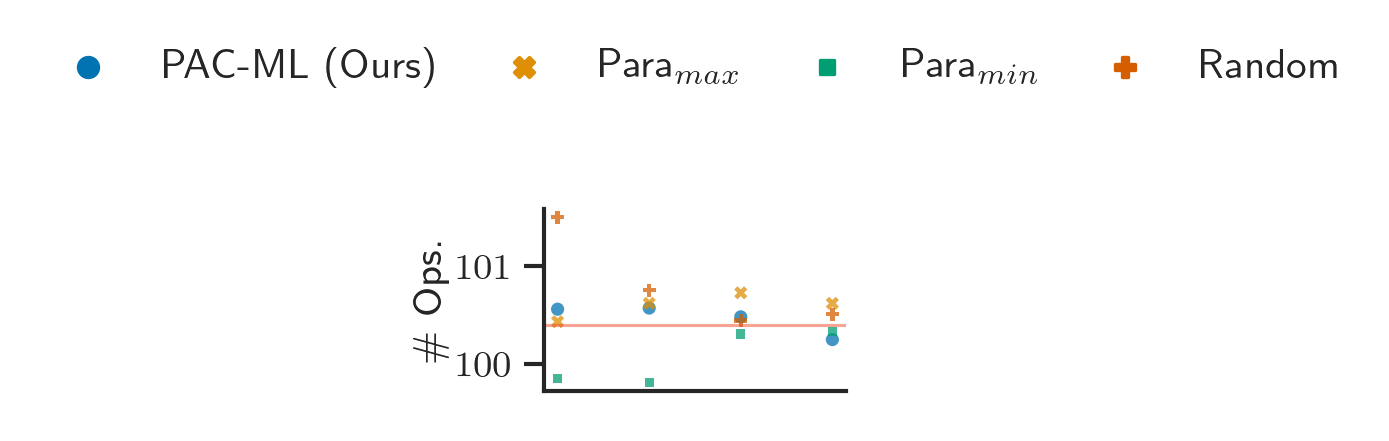


Metric: original_demand_total_operation_memory_cost
Completed:
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


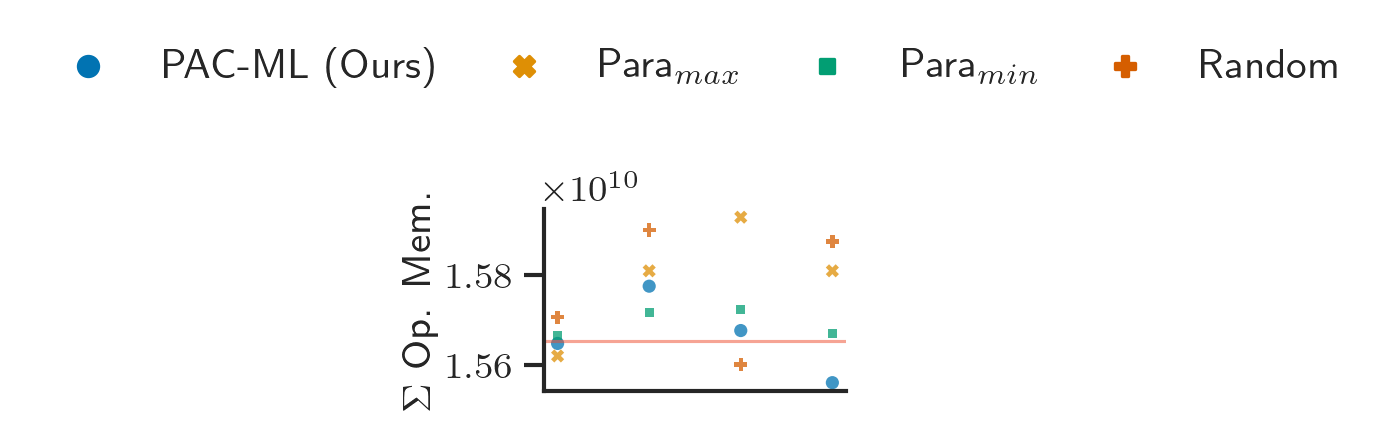


Metric: job_sequential_completion_time
Completed:
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


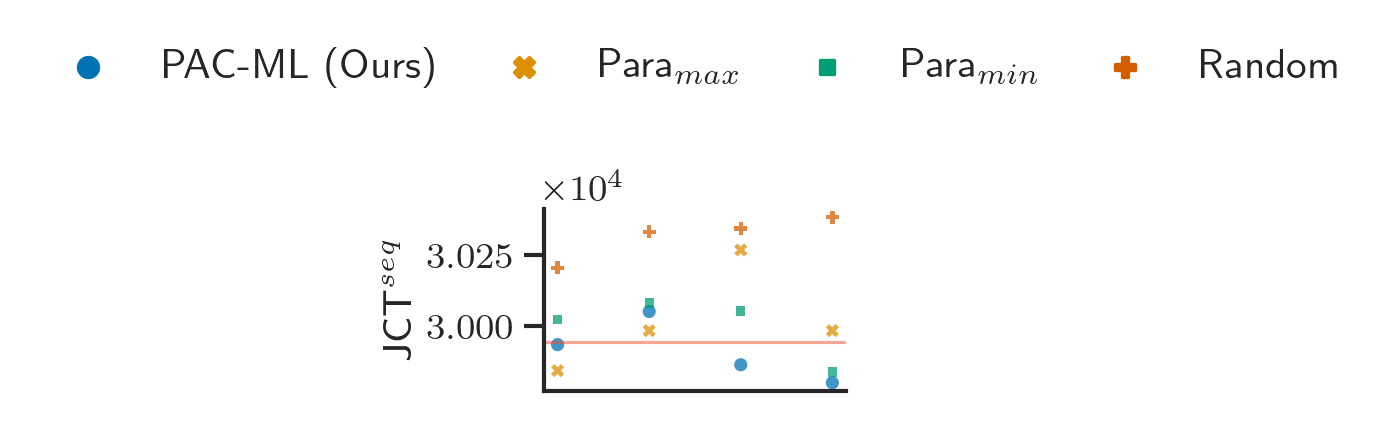


Metric: original_demand_num_edges
Completed:
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


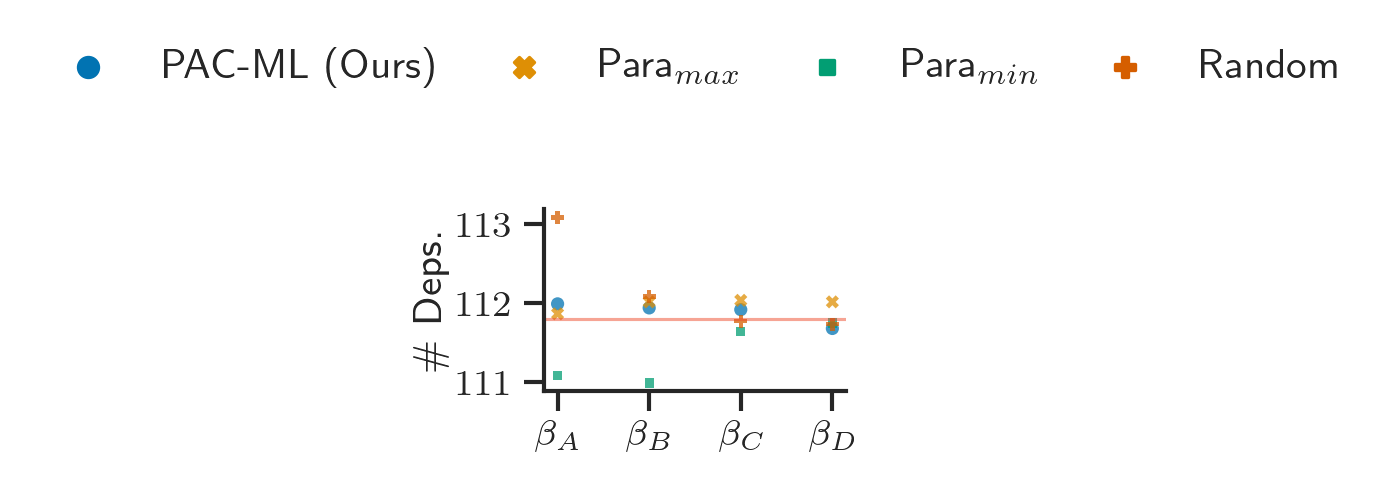


Metric: original_demand_total_dependency_size
Completed:
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


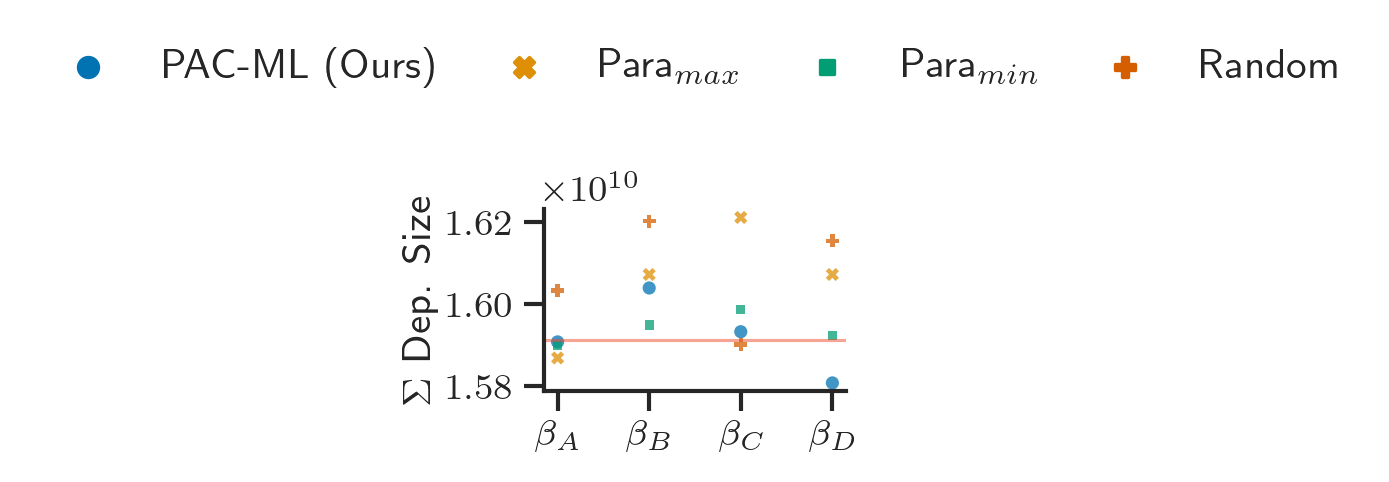


Metric: max_acceptable_job_completion_time_frac
Completed:
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


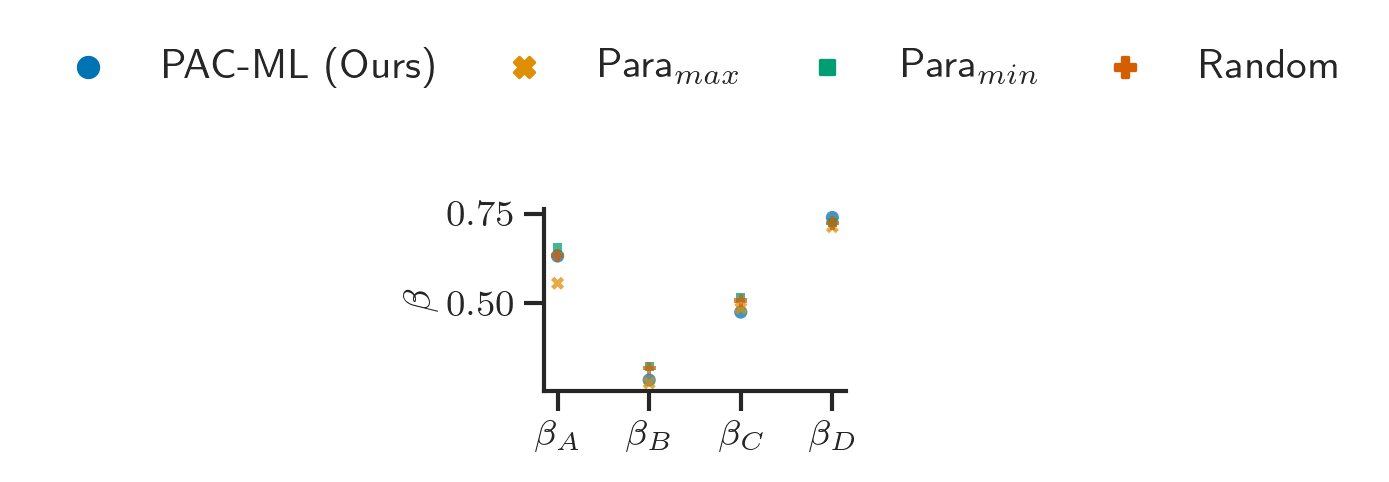


Metric: num_mounted_workers
Completed:
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


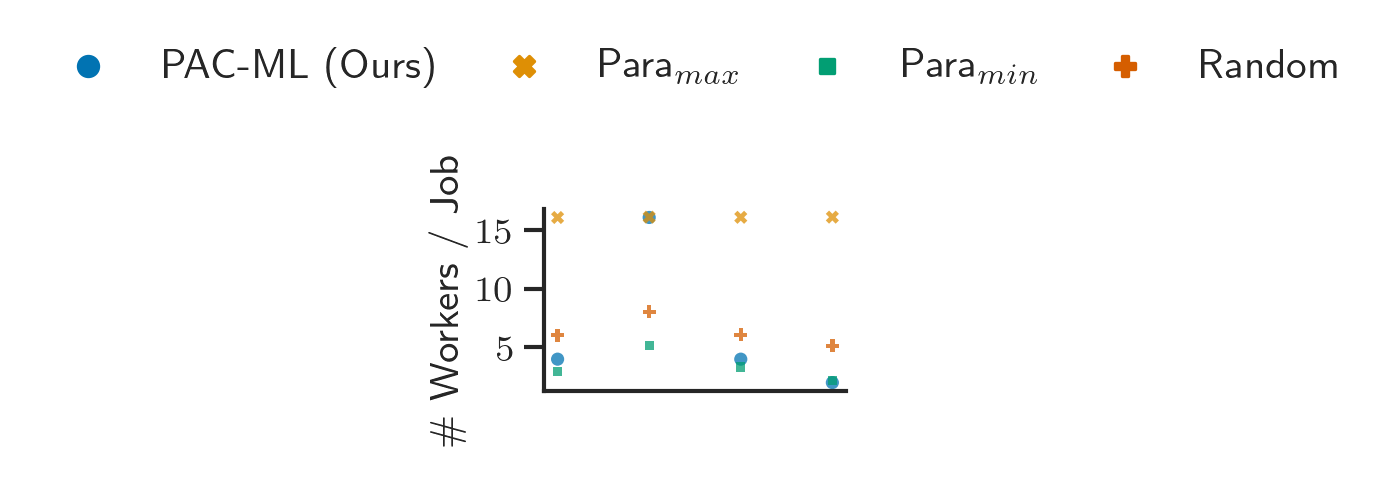


Metric: mean_mounted_worker_utilisation_frac
Completed:
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


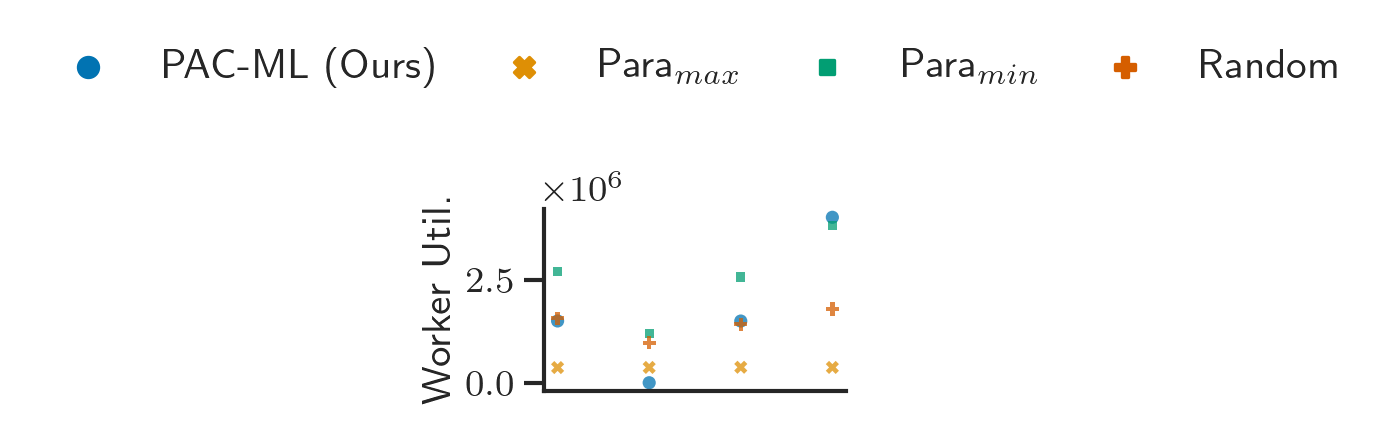

In [12]:
metrics = ['original_demand_num_nodes',
           'original_demand_total_operation_memory_cost',
           'job_sequential_completion_time',
           
           'original_demand_num_edges',
           'original_demand_total_dependency_size',
           
           'max_acceptable_job_completion_time_frac',
           
           'num_mounted_workers',
           'mean_mounted_worker_utilisation_frac',
           
          ]

for metric in metrics:
    print(f'\nMetric: {metric}')
    
    if metric in job_metric_to_mean.keys():
        mean_val = job_metric_to_mean[metric]
    else:
        mean_val = None
    
    print(f'Completed:')
    _metric = f'jobs_completed_{metric}'
    scatterplot(df=merged_completion_df, metric=_metric, mean_val=mean_val)
    
    # print(f'Blocked:')
    # _metric = f'jobs_blocked_{metric}'
    # scatterplot(df=merged_blocked_df, metric=_metric)
    
# metrics = ['mean_num_mounted_workers',
#           ]
# for metric in metrics:
#     print(f'Metric: {metric}')
#     mean_val = None
#     # scatterplot(df=merged_episode_df, metric=metric, mean_val=mean_val)
#     scatterplot(df=merged_completion_df, metric=metric, mean_val=mean_val)

# Performance Bar Charts

In [13]:
# add acceptance rate column to episode dfs
merged_episode_df['acceptance_rate'] = 1 - merged_episode_df['blocking_rate']
merged_episode_df = merged_episode_df.reset_index()
display(merged_episode_df)

,index,mean_mounted_worker_utilisation_frac,$\beta_{X}$,Agent,flow_info_processed,mean_num_jobs_running,mean_demand_compute_throughput,dep_info_processed,mean_cluster_worker_utilisation_frac,mean_demand_total_throughput,...,episode_end_time,blocking_rate,mean_demand_dep_throughput,episode_counter,mean_load_rate,cluster_info_processed,compute_info_processed,mean_communication_overhead_frac,return,experiment.seed
0,0,1.823921e+06,$\beta_{A}$,PAC-ML (Ours),2.643910e+13,5.637222,1.224705e+07,2.976742e+13,1.288622e+06,2.469843e+07,...,1000000.0,0.220890,1.245138e+07,5627.333333,3.155022e+07,4.201447e+13,1.224705e+13,0.000450,NaN,NaN
1,1,1.886147e-02,$\beta_{B}$,PAC-ML (Ours),9.009803e+13,1.483527,1.161790e+07,9.092543e+13,1.470066e-02,2.343145e+07,...,1000000.0,0.264069,1.181355e+07,1131.333333,3.153655e+07,1.025433e+14,1.161790e+13,0.002220,NaN,NaN
2,2,1.828066e+06,$\beta_{C}$,PAC-ML (Ours),2.975471e+13,6.318556,1.378251e+07,3.350312e+13,1.445153e+06,2.779106e+07,...,1000000.0,0.124653,1.400855e+07,1649.333333,3.157804e+07,4.728563e+13,1.378251e+13,0.000453,NaN,NaN
3,3,4.950165e+06,$\beta_{D}$,PAC-ML (Ours),1.390506e+13,13.325222,1.408587e+07,2.150653e+13,4.125504e+06,2.840079e+07,...,1000000.0,0.103674,1.431492e+07,892.666667,3.156887e+07,3.559240e+13,1.408587e+13,0.000189,NaN,NaN
4,0,NaN,$\beta_{A}$,Para$_{max}$,8.940979e+13,NaN,1.153111e+07,9.023103e+13,NaN,2.324682e+07,...,1000000.0,0.262404,1.171571e+07,NaN,3.152110e+07,1.017621e+14,1.153111e+13,NaN,476.000000,1.0
5,1,NaN,$\beta_{B}$,Para$_{max}$,9.038632e+13,NaN,1.165623e+07,9.121688e+13,NaN,2.350566e+07,...,1000000.0,0.263070,1.184942e+07,NaN,3.161569e+07,1.028731e+14,1.165623e+13,NaN,475.333333,1.0
6,2,NaN,$\beta_{C}$,Para$_{max}$,9.054285e+13,NaN,1.167454e+07,9.137444e+13,NaN,2.355580e+07,...,1000000.0,0.267399,1.188126e+07,NaN,3.161214e+07,1.030490e+14,1.167454e+13,NaN,466.666667,1.0
7,3,NaN,$\beta_{D}$,Para$_{max}$,9.038632e+13,NaN,1.165623e+07,9.121688e+13,NaN,2.350566e+07,...,1000000.0,0.263070,1.184942e+07,NaN,3.161569e+07,1.028731e+14,1.165623e+13,NaN,475.333333,1.0
8,4,NaN,$\beta_{A}$,Para$_{min}$,1.459394e+13,NaN,1.093512e+07,1.931156e+13,NaN,2.204008e+07,...,1000000.0,0.308691,1.110496e+07,NaN,3.156138e+07,3.024668e+13,1.093512e+13,NaN,402.000000,1.0
9,5,NaN,$\beta_{B}$,Para$_{min}$,2.354048e+13,NaN,9.545898e+06,2.568106e+13,NaN,1.923322e+07,...,1000000.0,0.395604,9.687327e+06,NaN,3.161214e+07,3.522696e+13,9.545898e+12,NaN,216.000000,1.0


In [95]:
def normalise_performance_bar_df(df, xaxis, metric, goal='maximise'):
    '''Normalises y-values at each x-value group in the bar chart.'''
    grouped_by_xaxis_df = df.groupby([xaxis])
    for x_val, item in grouped_by_xaxis_df:
        if goal == 'maximise':
            item[metric] /= np.max(item[metric])
        else:
            item[metric] = 1 - ( 1 - (np.min(item[metric]) / item[metric]) )
            # item[metric] = 1 - (np.min(item[metric]) / item[metric])
        for idx, val in zip(item[metric].index, item[metric]):
            df[metric].iat[idx] = val
    return df


def barplot(df, metric):
    
    
    
    aesthetics = PlotAesthetics()
    aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

    # scaling_factor = 1.5
    # scaling_factor = 0.6
    scaling_factor = 0.7
    # scaling_factor = 2
    width_scaling_factor = 1
    height_scaling_factor = 1
    
    metric_to_yaxis_label = {
        'episode_reward': 'Episode Return',
        'mean_cluster_throughput': 'Cluster Throughput',
        # 'mean_demand_total_throughput': 'Offered\nThroughput (B/s)',
        'mean_demand_total_throughput': 'Throughput',
        'blocking_rate': 'Blocking Rate',
        'acceptance_rate': 'Acceptance Rate',
        'job_completion_time': 'JCT',
        'job_completion_time_speedup': 'JCT Speed-Up',
        'score': 'Score',
    }
    
    xaxis = '$\\beta_{X}$'
    
    hue = 'Agent'
    style = 'Agent'
    
    # legend = 'auto'
    legend = None
    
    # set hue order for colour palette
    hue_order = list(learner_agent_to_beta_dist_to_run_path.keys())
    hue_order.extend(list(baseline_agent_to_beta_dist_to_sweep_path.keys()))
    print(f'hue_order: {hue_order}')
    
    # generate colour for each agent given hue order and colour palette
    _palette = iter(sns.color_palette(aesthetics.palette))
    palette = {agent: next(_palette) for agent in hue_order}
    print(palette)
    
    xlog = False
    ylog = False
    
    if metric in ['mean_demand_total_throughput', 'job_completion_time']:
        yaxis_label_style = 'sci'
    else:
        yaxis_label_style = 'plain'
    # yaxis_label_style = 'plain'
                
    show_xaxis_title = False
    
    # if 'job_completion_time' in metric:
    #     # bottom plot, show xaxis
    #     show_xaxis = True
    # else:
    #     # top plot, hide xaxis
    #     show_xaxis = False
    show_xaxis = True
    
    
    normalise = True
    metric_to_yaxis_label[metric] += ' Score'
    # normalise = False
    # if metric == 'acceptance_rate':
    #     normalise = True
    #     metric_to_yaxis_label[metric] += '\n(Normalised)'
    # else:
    #     normalise = False
    if normalise:
        if metric == 'blocking_rate':
            goal = 'minimise'
        else:
            goal = 'maximise'
        df = normalise_performance_bar_df(df=df, xaxis=xaxis, metric=metric, goal=goal)
    
    # ylim = None
    # ylim = [0.5, 1]
    ylim = [0.9 * np.min(df[metric]), None]
    # ylim = [-0.1, None]
    
    
    # print(f'Plotting metric {metric} -> min={np.min(df[metric+"_mean"])} | max={np.max(df[metric+"_mean"])} | mean={np.mean(df[metric+"_mean"])}')
        
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    
    g = sns.barplot(data=df, 
                     x=xaxis, 
                     y=metric, 
                     hue=hue, 
                     # legend=legend,
                     palette=palette,
                    )
    if legend is not None:
        handles, lables = g.get_legend_handles_labels()
        # for h in handles:
        #     h.set_markersize(marker_size)
        ax.legend(loc='upper center', 
                  bbox_to_anchor=(0.5, 1.4), 
                  ncol=4,
                  # ncol=5,
                  labelspacing=0.1, 
                  columnspacing=1, 
                  prop={'size': 10},
                  title=None,
                  frameon=False,
                 )
    else:
        g.legend_.remove()
    g.set_ylabel(metric_to_yaxis_label[metric])
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    sns.despine(ax=ax) # remove top and right spines
    if xlog:
        g.set(xscale='log')
    if ylog:
        g.set(yscale='log')
    if not show_xaxis_title:
        ax.xaxis.set_label_text('')
    if not show_xaxis:
        ax.get_xaxis().set_visible(False)
    if ylim is not None:
        plt.ylim(ylim)
    plt.gcf().patch.set_alpha(0.0)
    plt.show()


Metric: blocking_rate
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


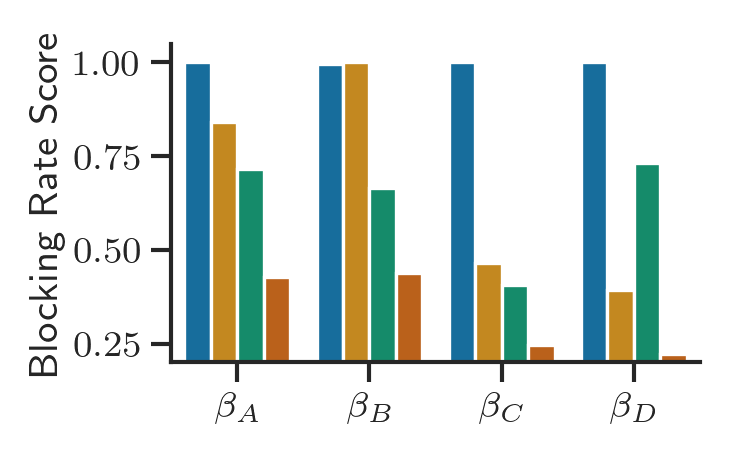


Metric: mean_demand_total_throughput
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


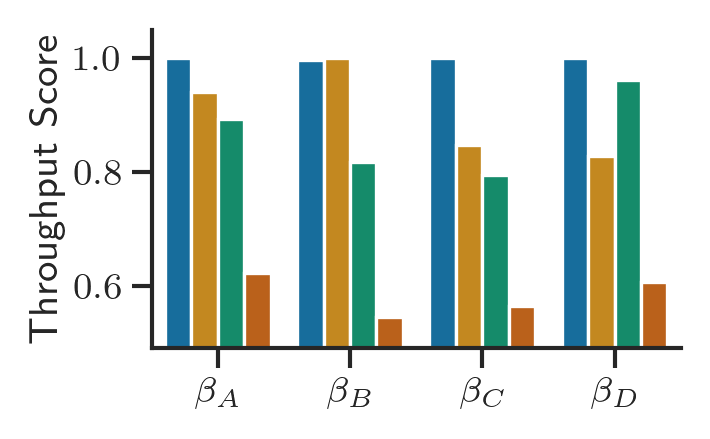

In [96]:
# episode stats
# metrics = ['blocking_rate', 'acceptance_rate', 'mean_demand_total_throughput']
metrics = ['blocking_rate', 'mean_demand_total_throughput']
# metrics = ['acceptance_rate']
for metric in metrics:
    print(f'\nMetric: {metric}')
    barplot(df=copy.deepcopy(merged_episode_df), metric=metric)
    
# # jobs completed stats
# metrics = ['job_completion_time', 'job_completion_time_speedup']
# for metric in metrics:
#     print(f'\nMetric: {metric}')
#     barplot(df=copy.deepcopy(merged_completion_df), metric=metric)